In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import const as CONST
from utils import read_csv_ts
from darts import TimeSeries
import matplotlib
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
import seaborn as sns

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20, 10)
COLORS = [
    "red", "green", "blue", "purple", "cyan", "olive", "gray", "brown", "pink"
]

In [8]:
ds = load_datasets()

INFO:Dataset:Loading dataset from data/preprocessed/datasets.pkl


In [9]:
print(f"Data starts: {ds.original.series[0].start_time()}")
print(f"Data ends: {ds.original.series[0].end_time()}, len = {len(ds.original.series[0])}")
print(f"Train data starts: {ds.original.train[0].start_time()}, len = {len(ds.original.train[0])}")
print(f"Validation data starts: {ds.original.val[0].start_time()}, len = {len(ds.original.val[0])}")
print(f"Test data starts: {ds.original.test[0].start_time()}, len = {len(ds.original.test[0])}")

Data starts: 2008-01-02 00:00:00
Data ends: 2023-03-10 00:00:00, len = 3824
Train data starts: 2008-01-02 00:00:00, len = 3059
Validation data starts: 2020-02-27 00:00:00, len = 382
Test data starts: 2021-09-01 00:00:00, len = 383


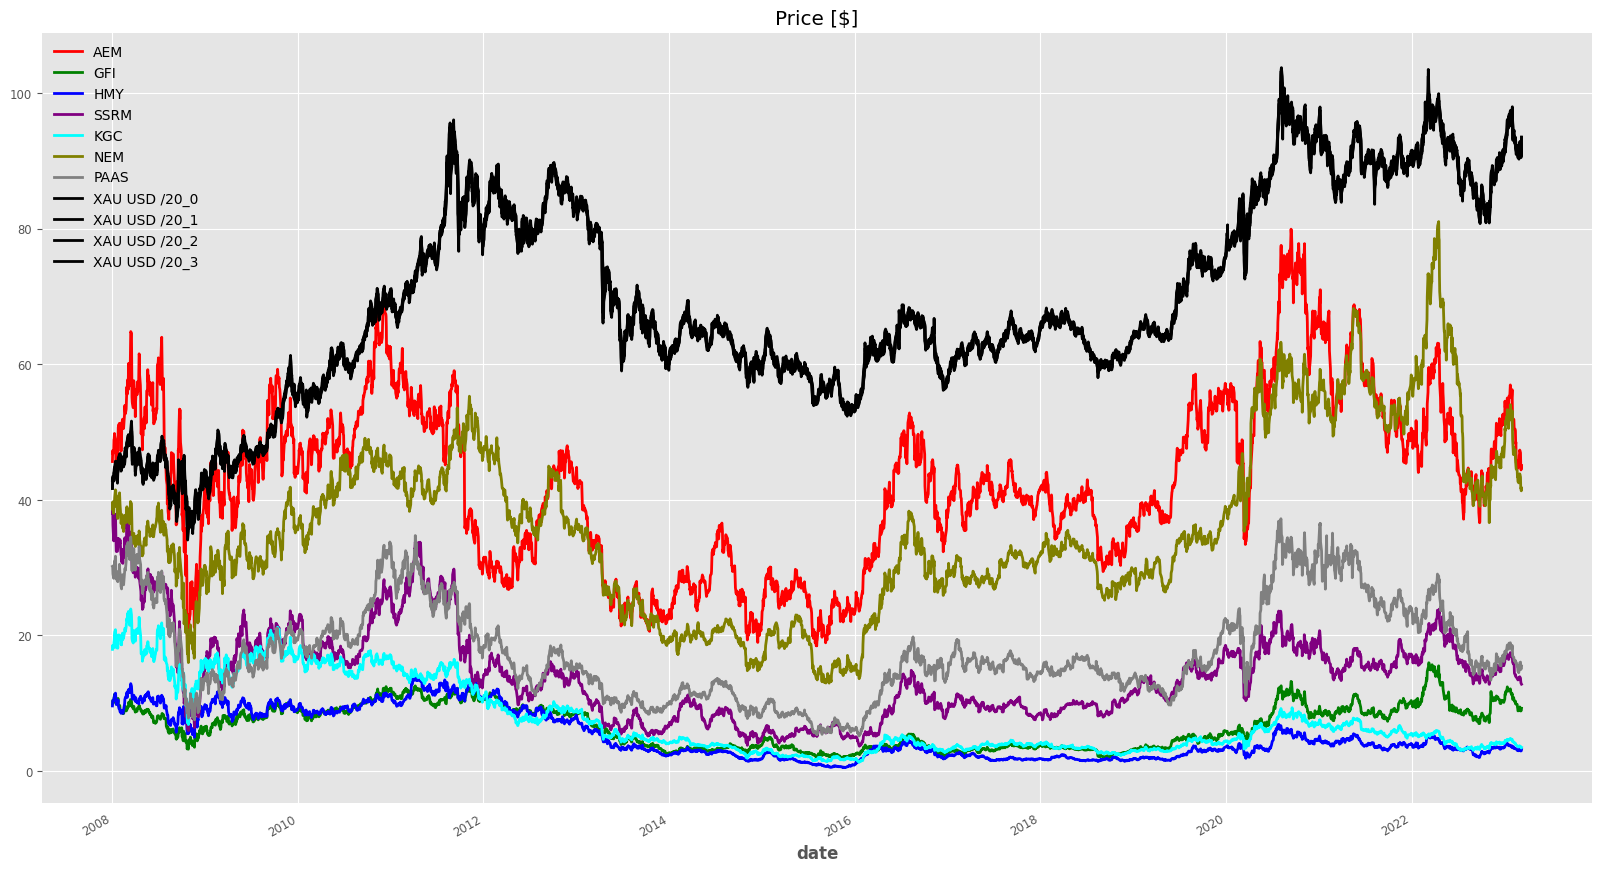

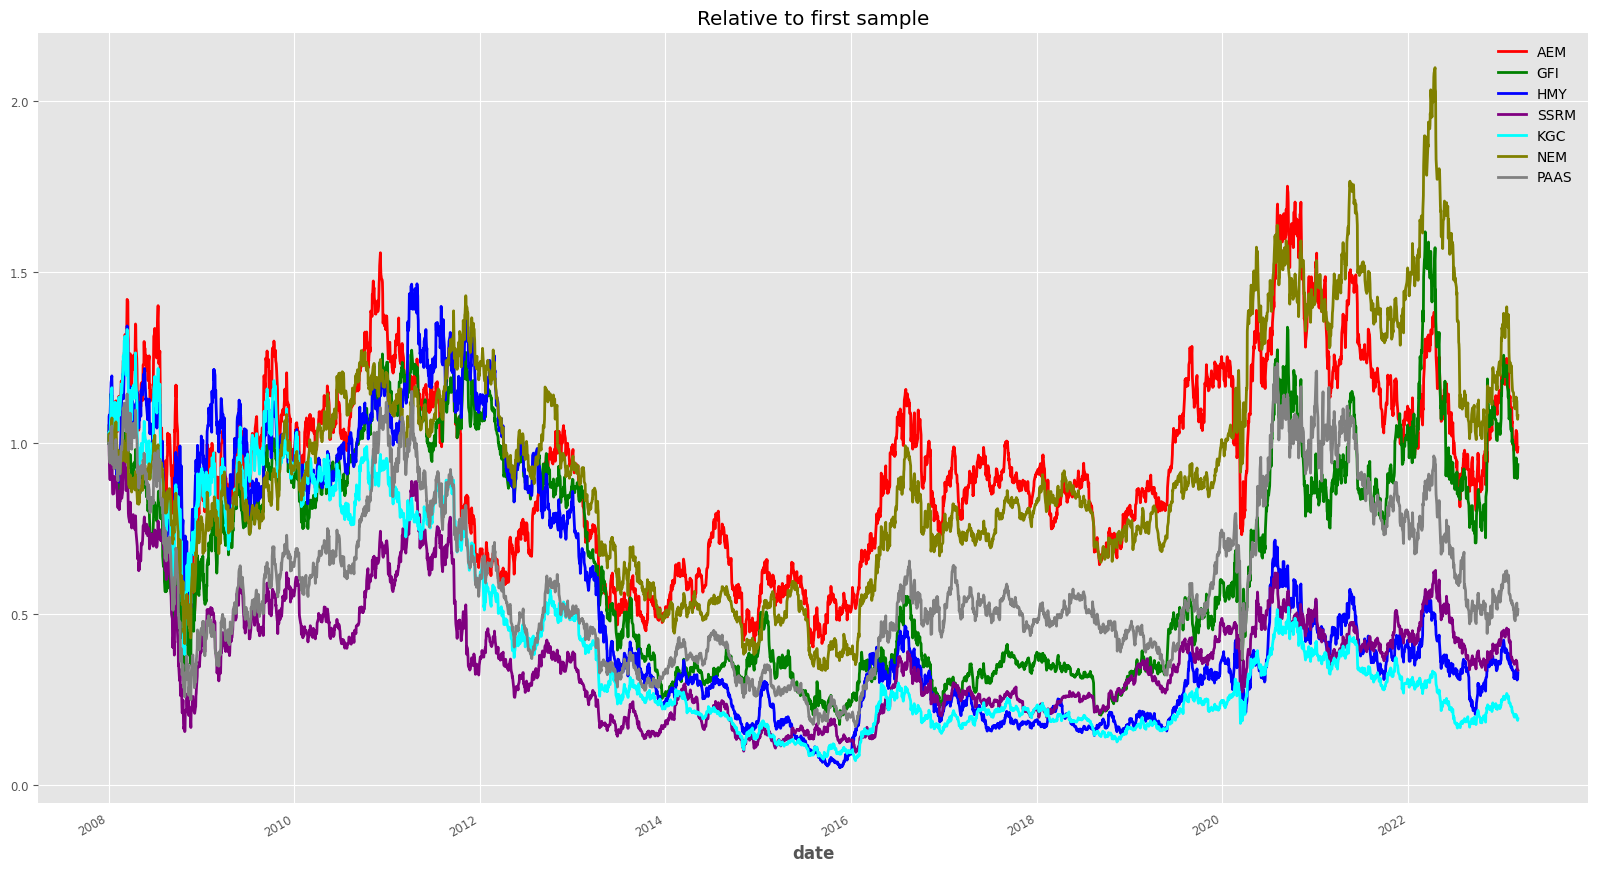

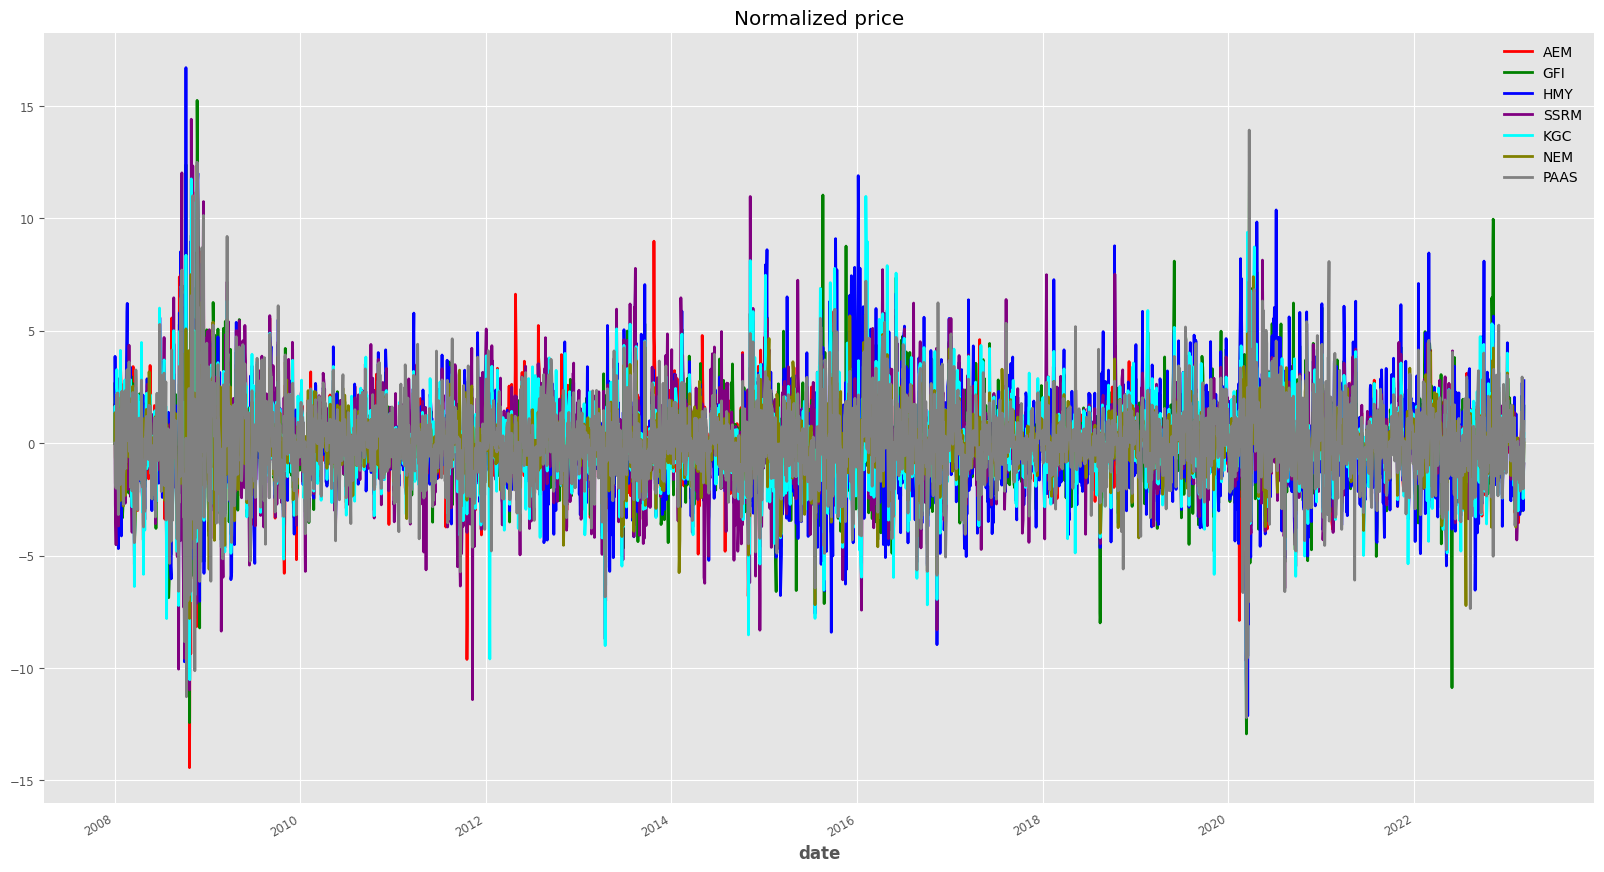

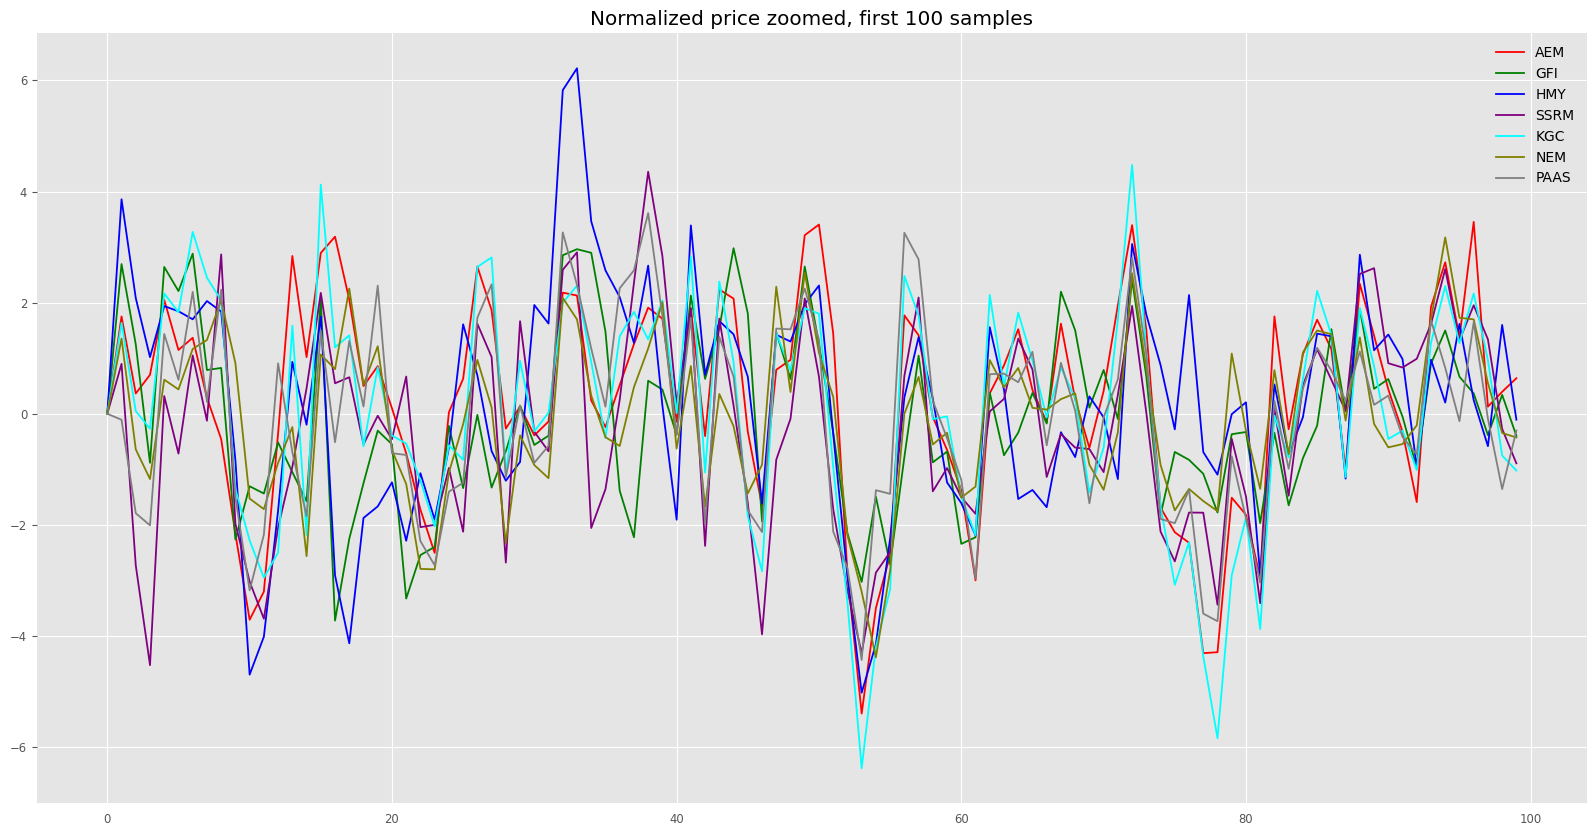

In [10]:
for idx,ticker in enumerate(ds.original.used_tickers):
    ds.original.series[idx].plot(label=ticker,color = COLORS[idx])
gold_ts = TimeSeries.from_dataframe(read_csv_ts("data/daily/GOLD.csv"))
(gold_ts/20).plot(label="XAU USD /20", color="black")
plt.title("Price [$]")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    (ds.original.series[idx]/ ds.original.series[idx].first_value()).plot(label=ticker, color = COLORS[idx])
plt.title("Relative to first sample")
plt.show()

for idx,ticker in enumerate(ds.original.used_tickers):
    ds.transformed.series[idx].plot(label=ticker,color = COLORS[idx])
plt.title("Normalized price")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.plot(ds.transformed.series[idx][0:100].values(),label=ticker,color = COLORS[idx])
plt.legend(ds.original.used_tickers)
plt.title("Normalized price zoomed, first 100 samples")
plt.show()

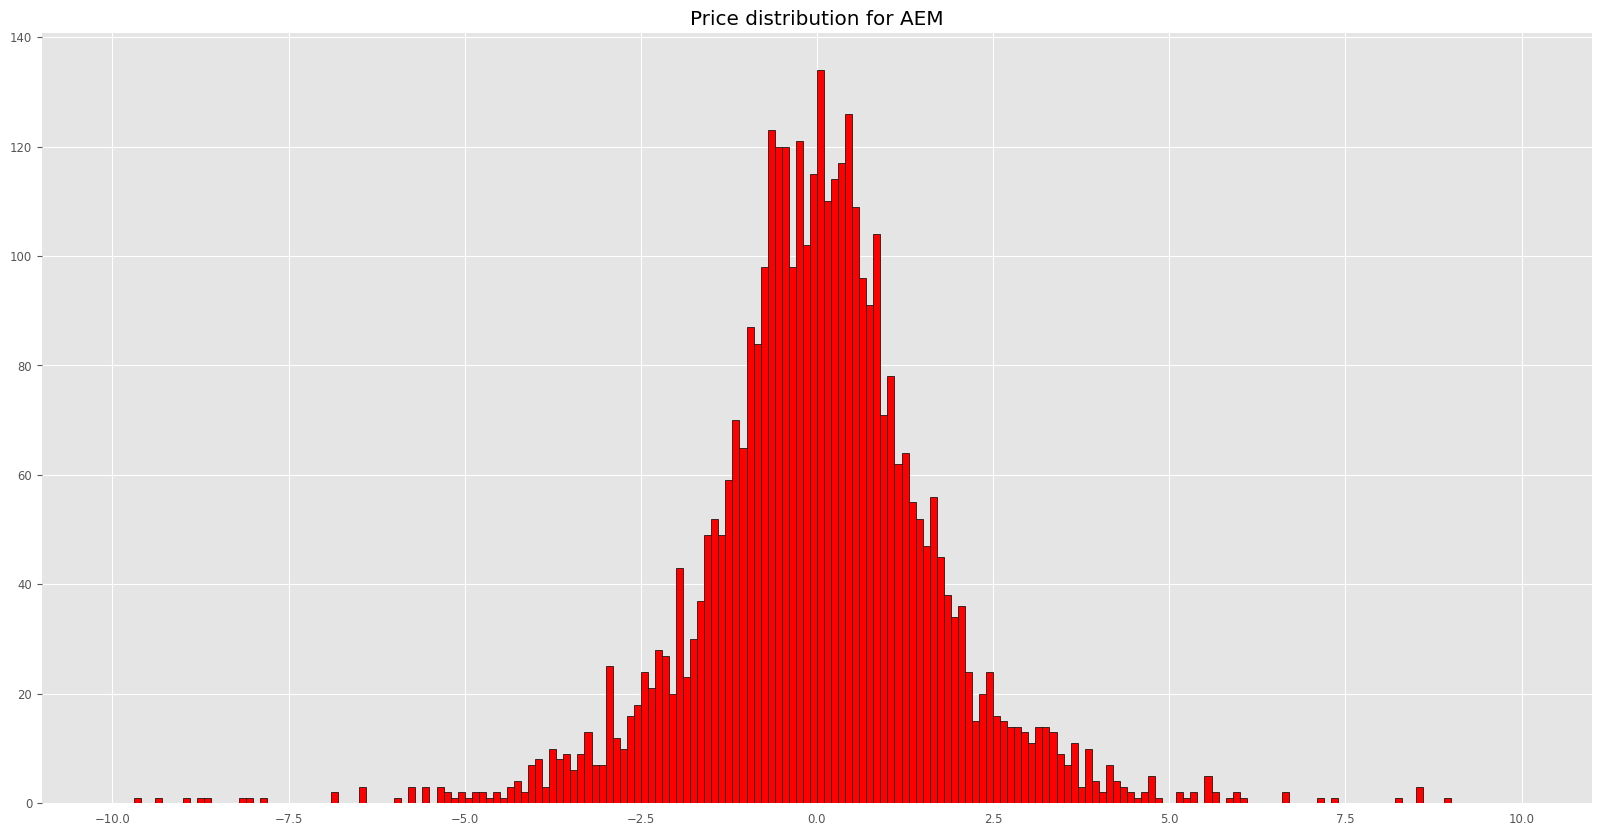

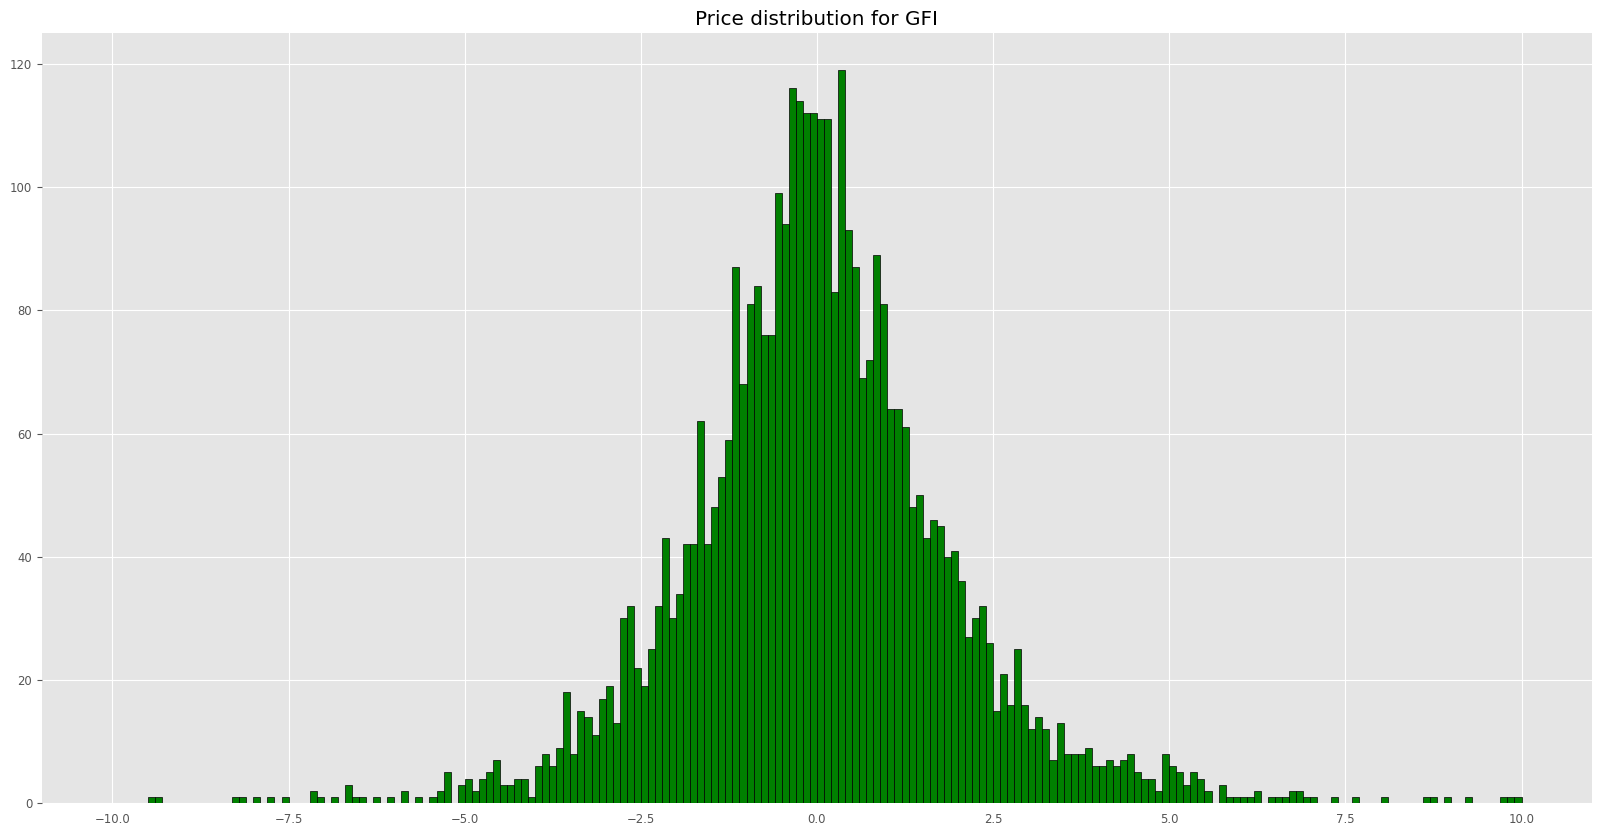

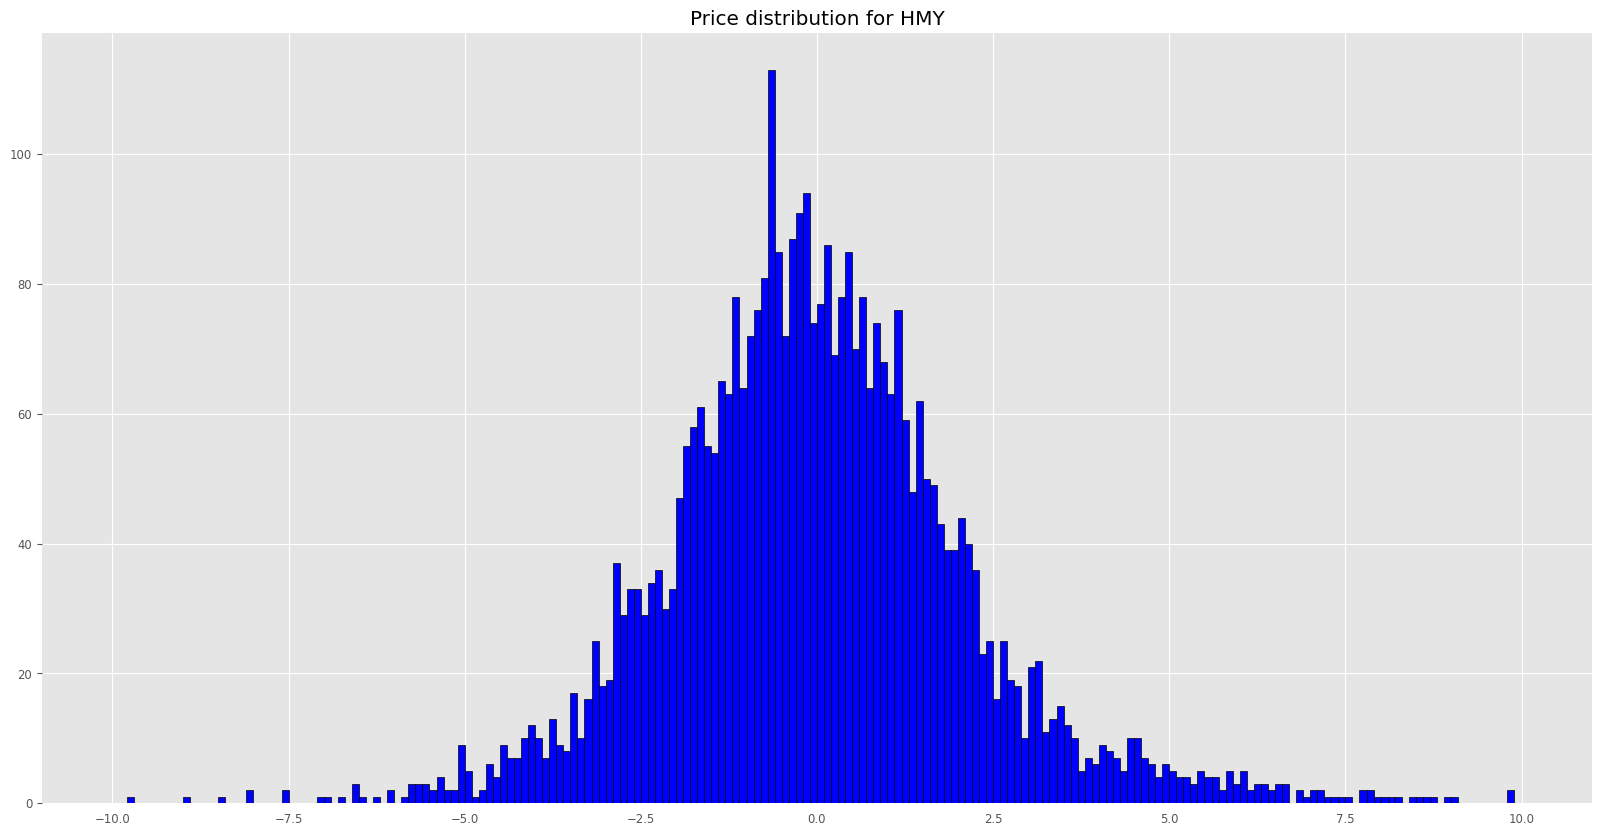

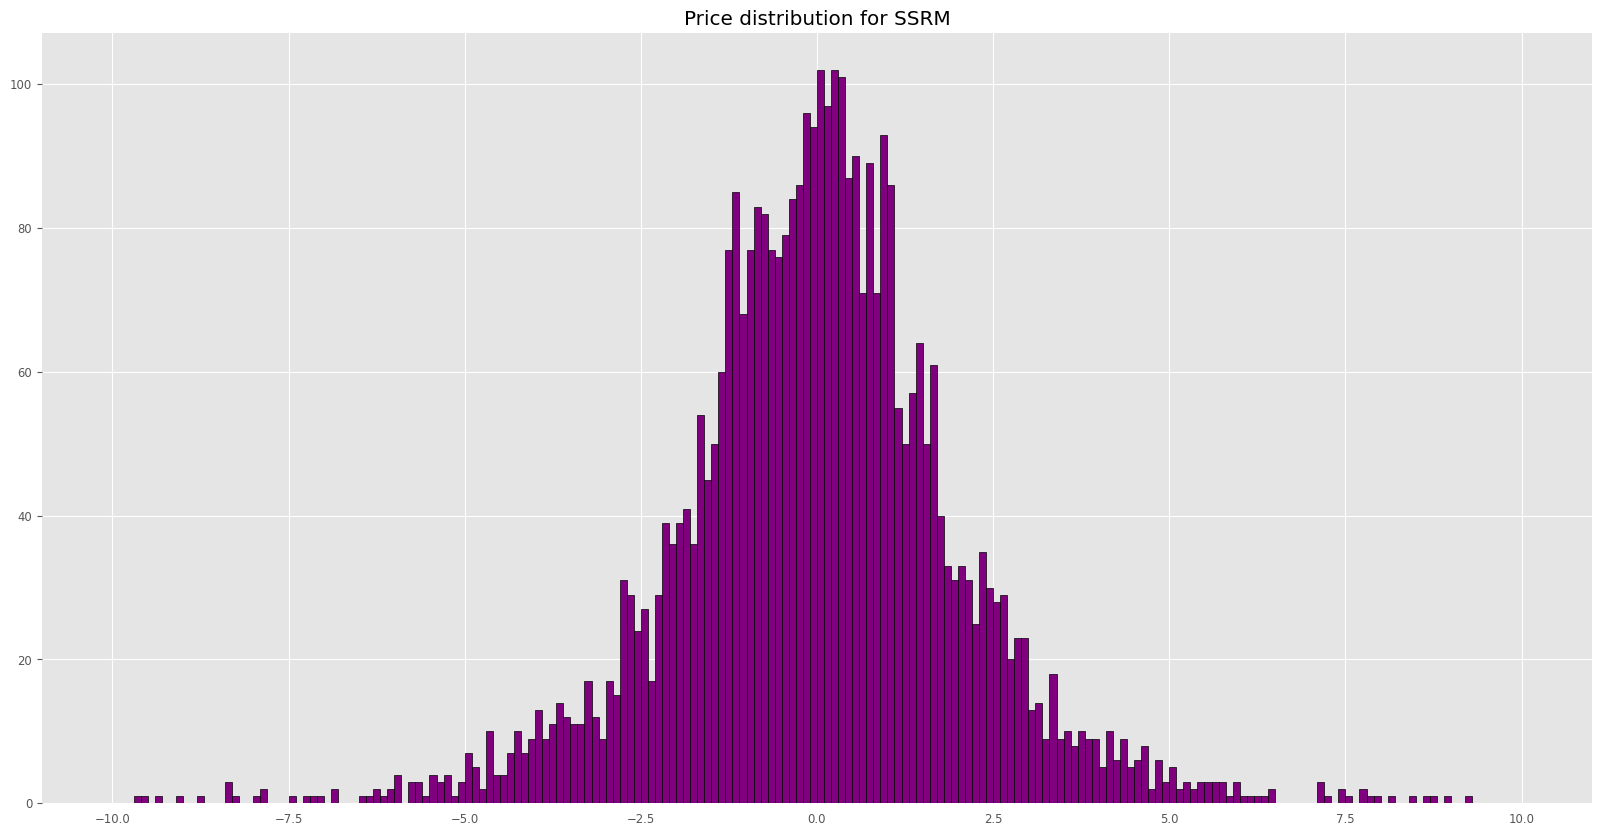

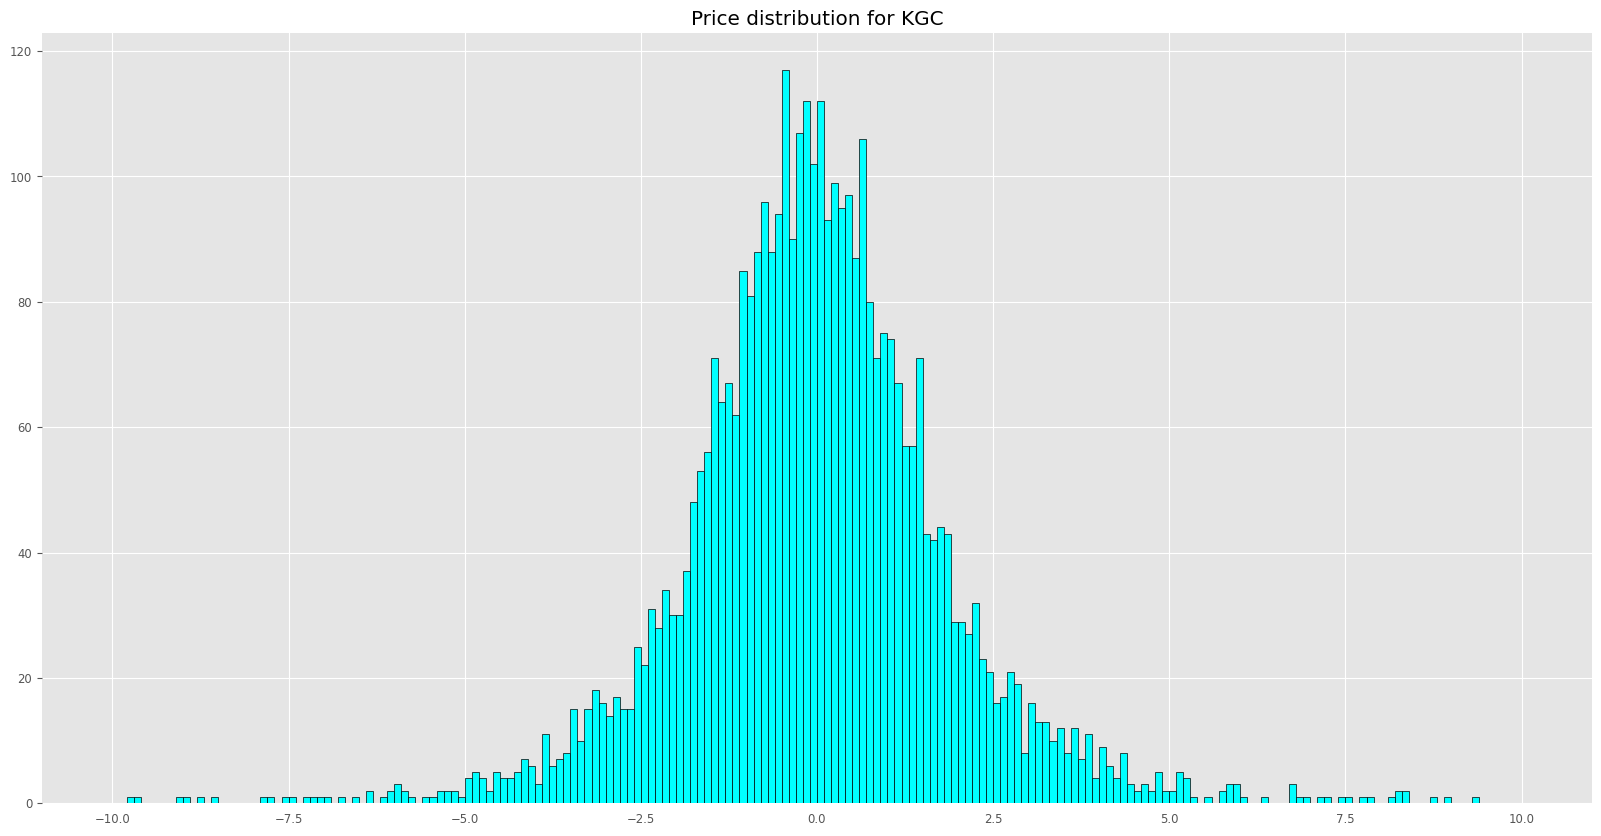

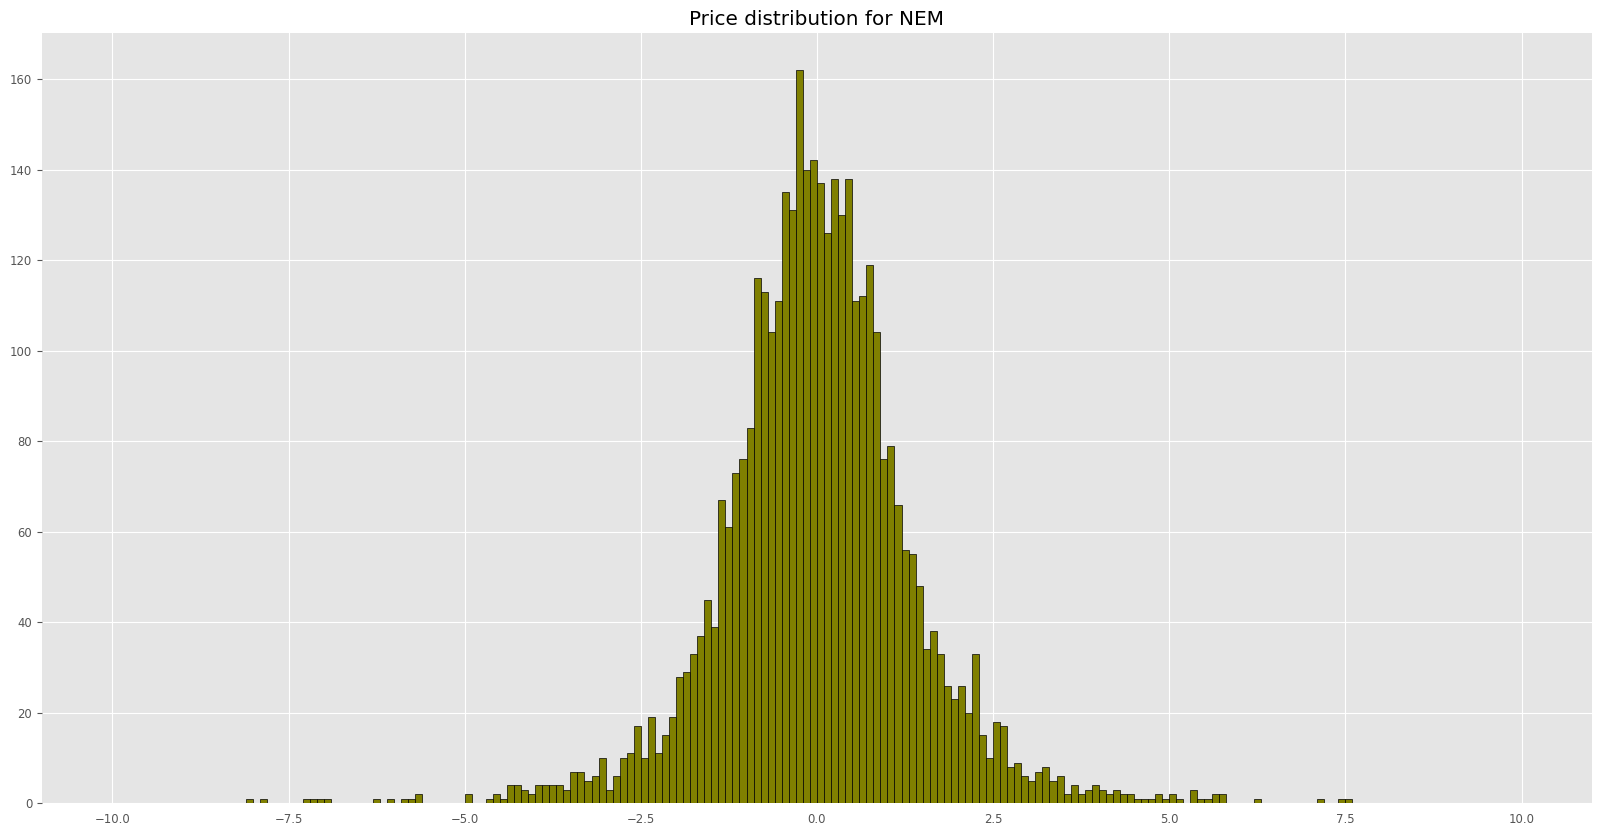

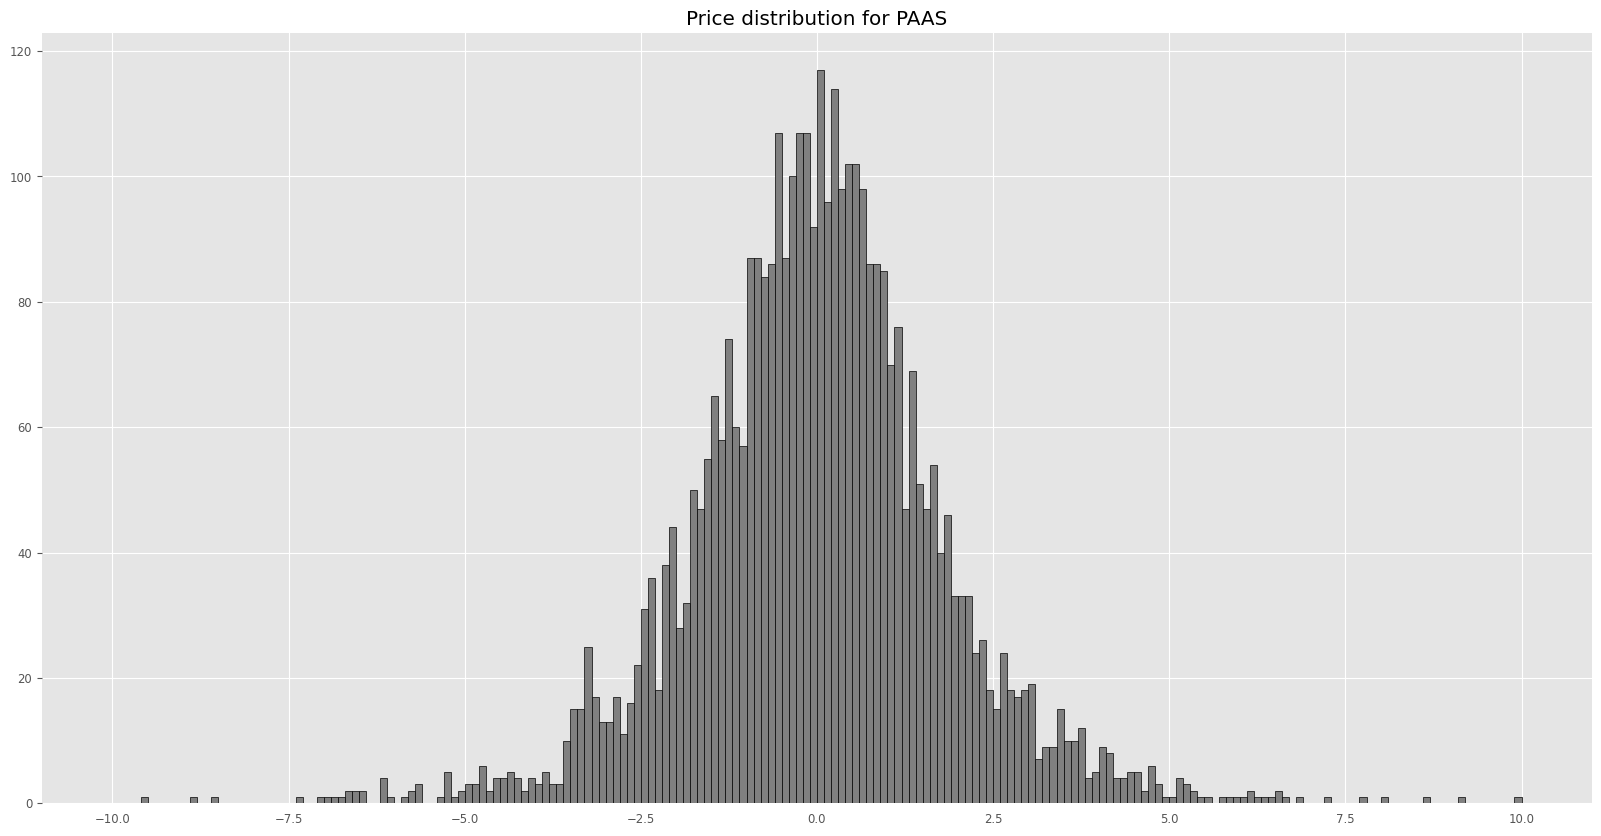

In [13]:
bins= [x / 10 for x in range(-100,101)]
for idx,ticker in enumerate(ds.original.used_tickers):
    plt.hist(ds.transformed.series[idx].values(), bins= bins, color=COLORS[idx], edgecolor='black')
    plt.title("Price distribution for "+ticker)
    plt.show()

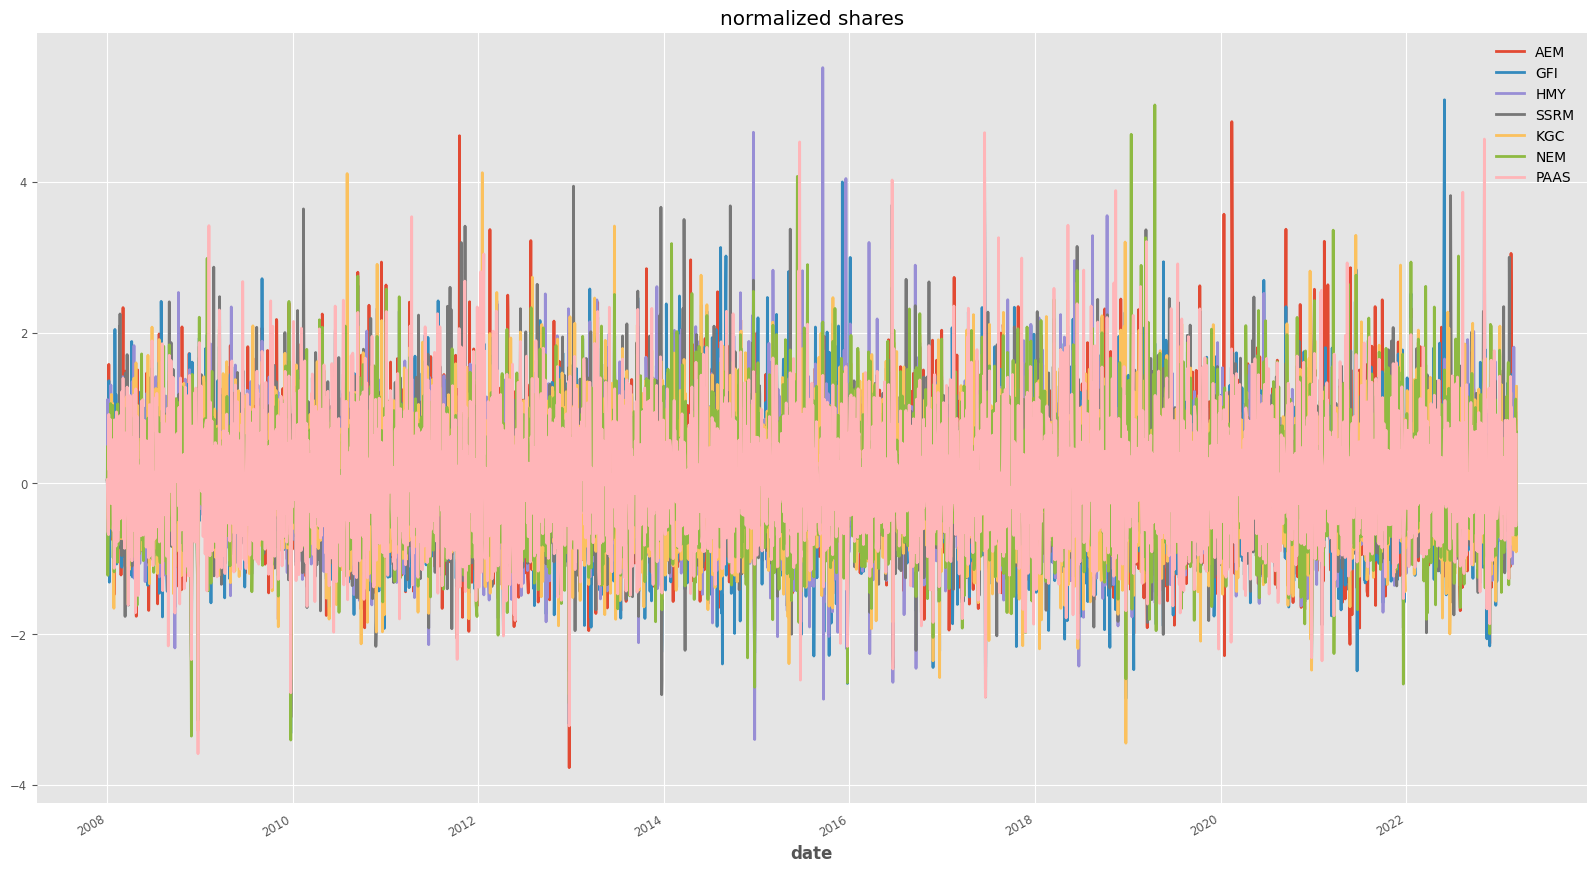

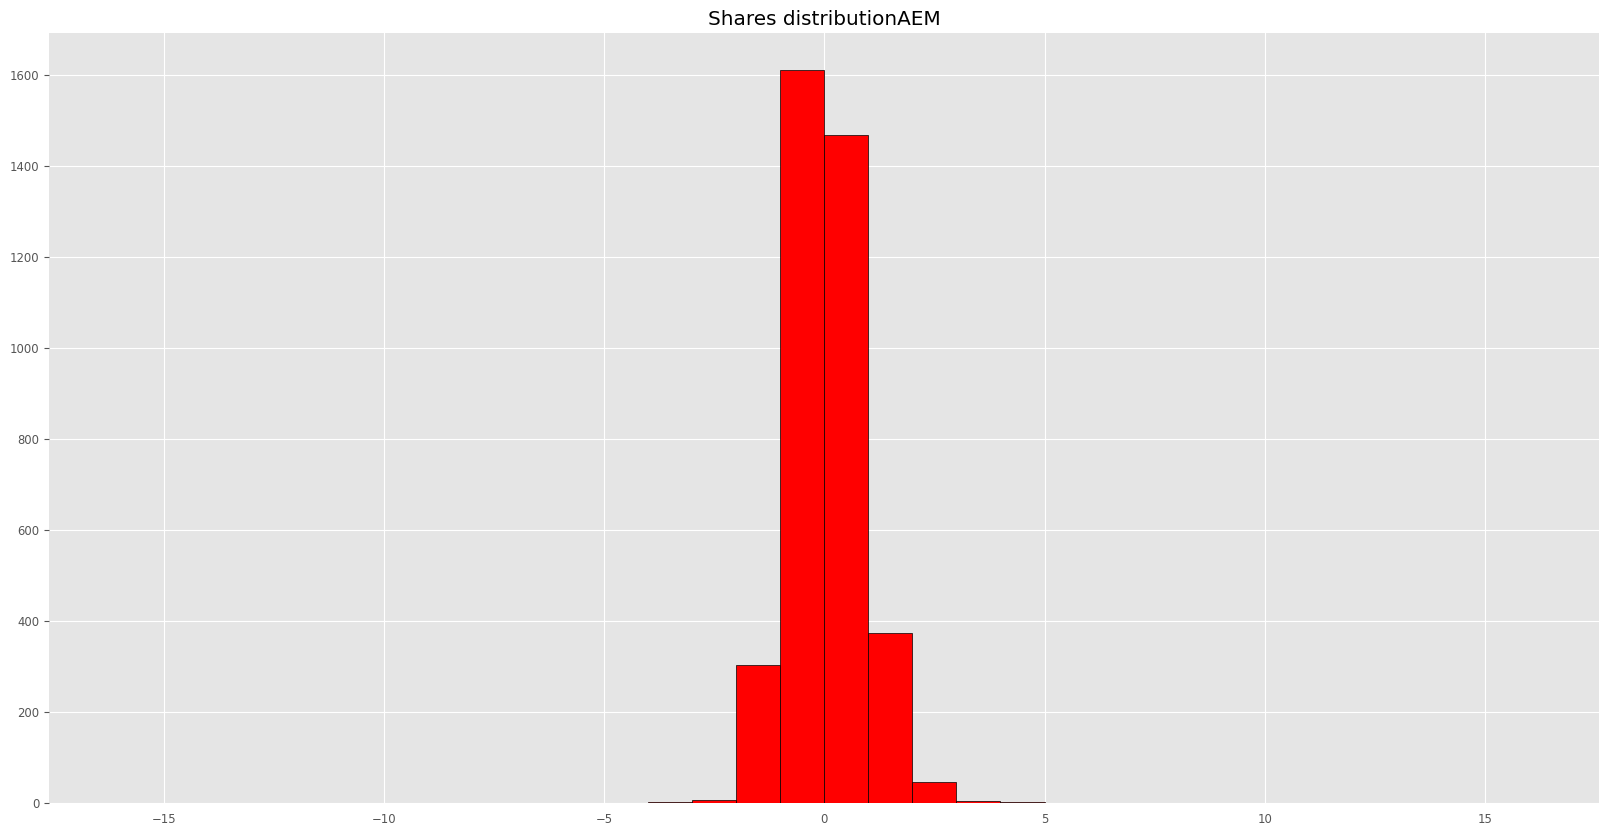

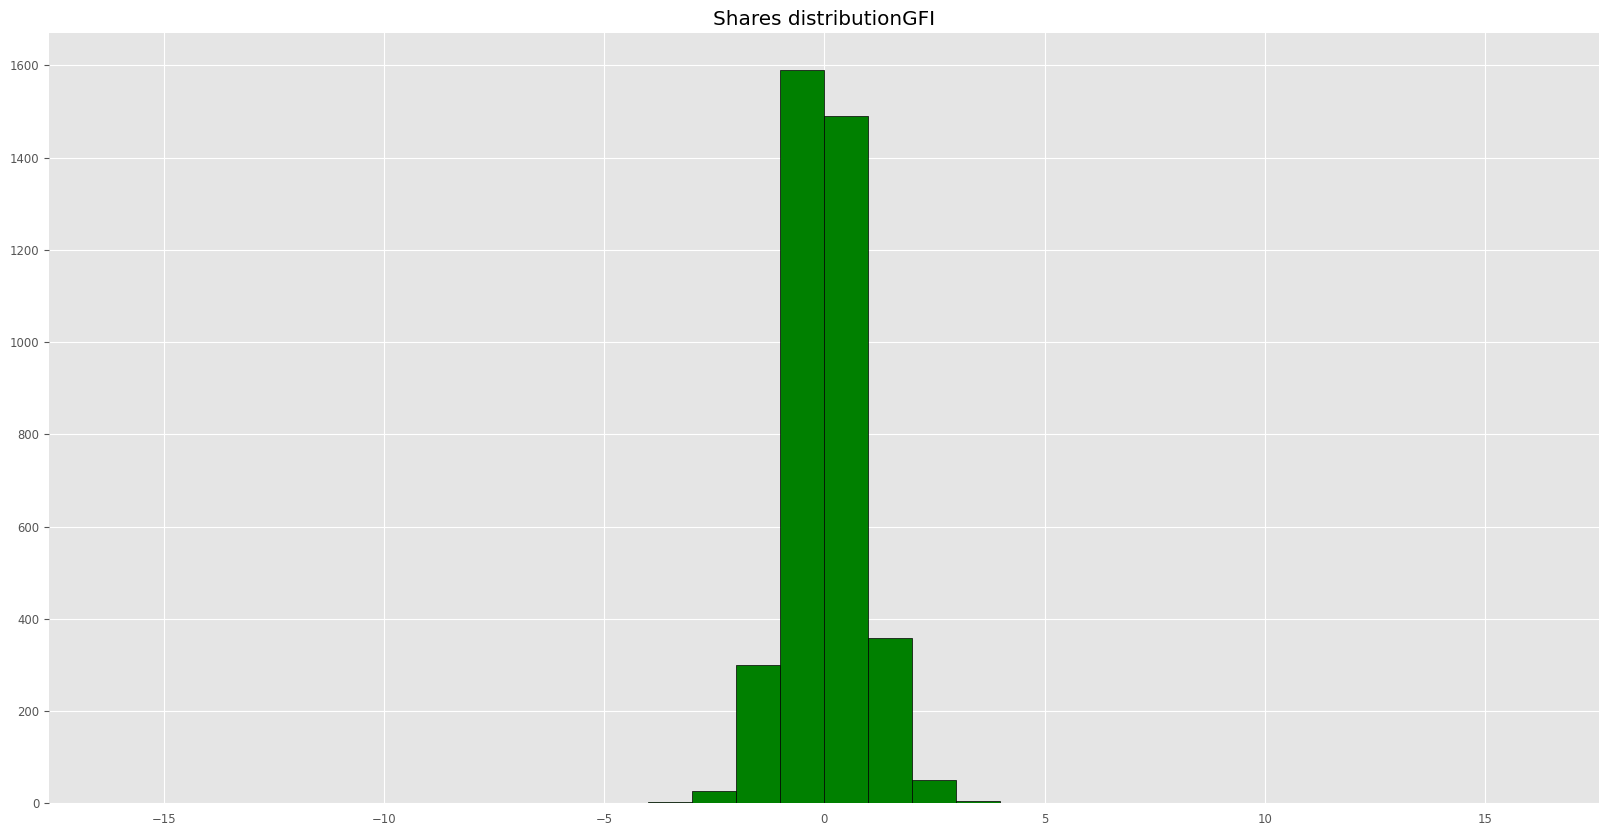

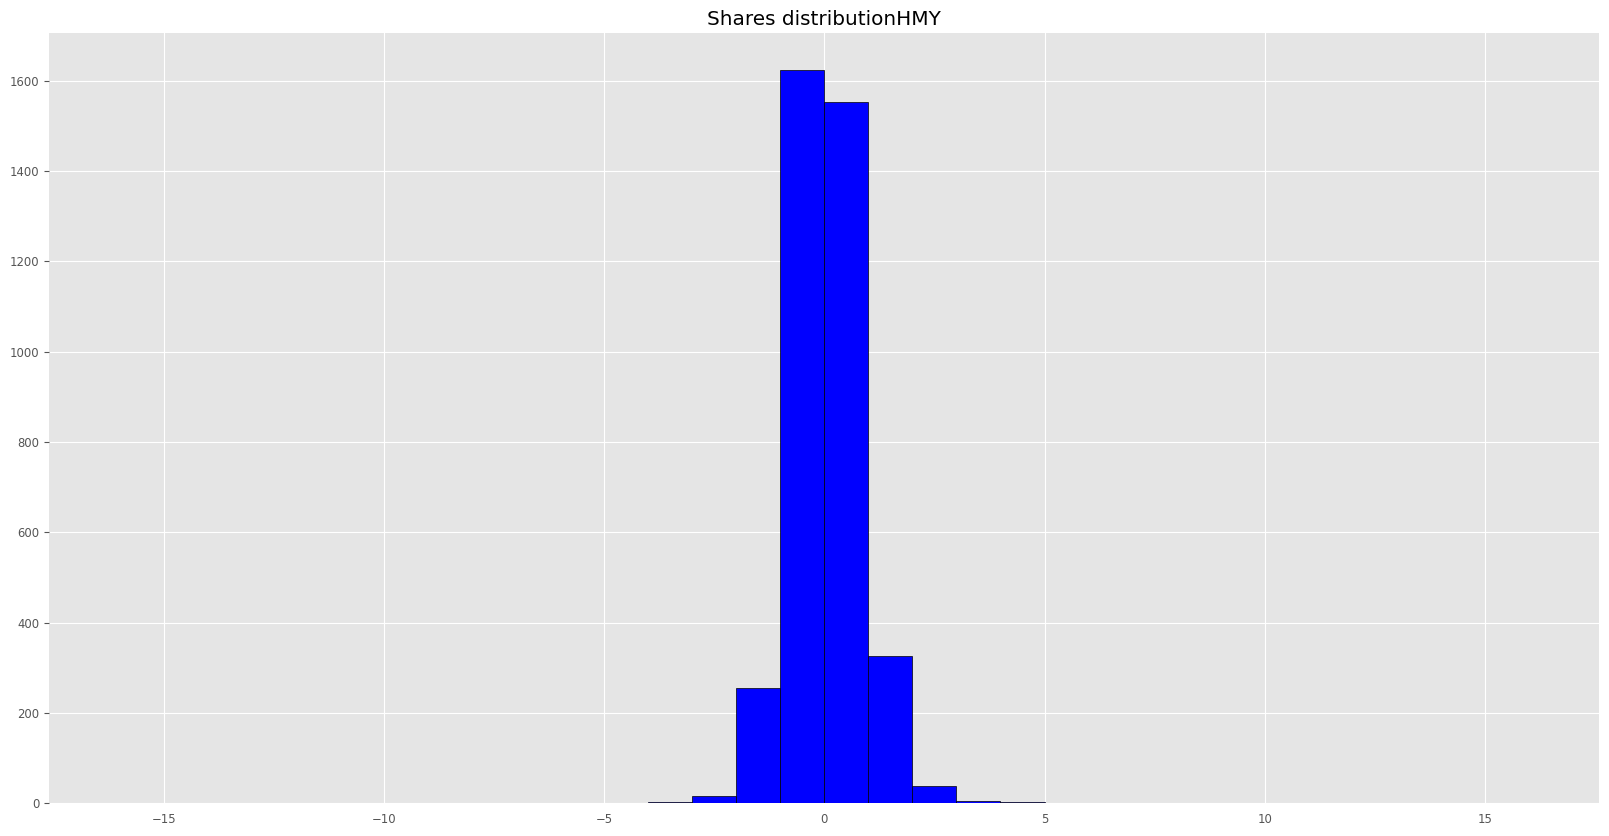

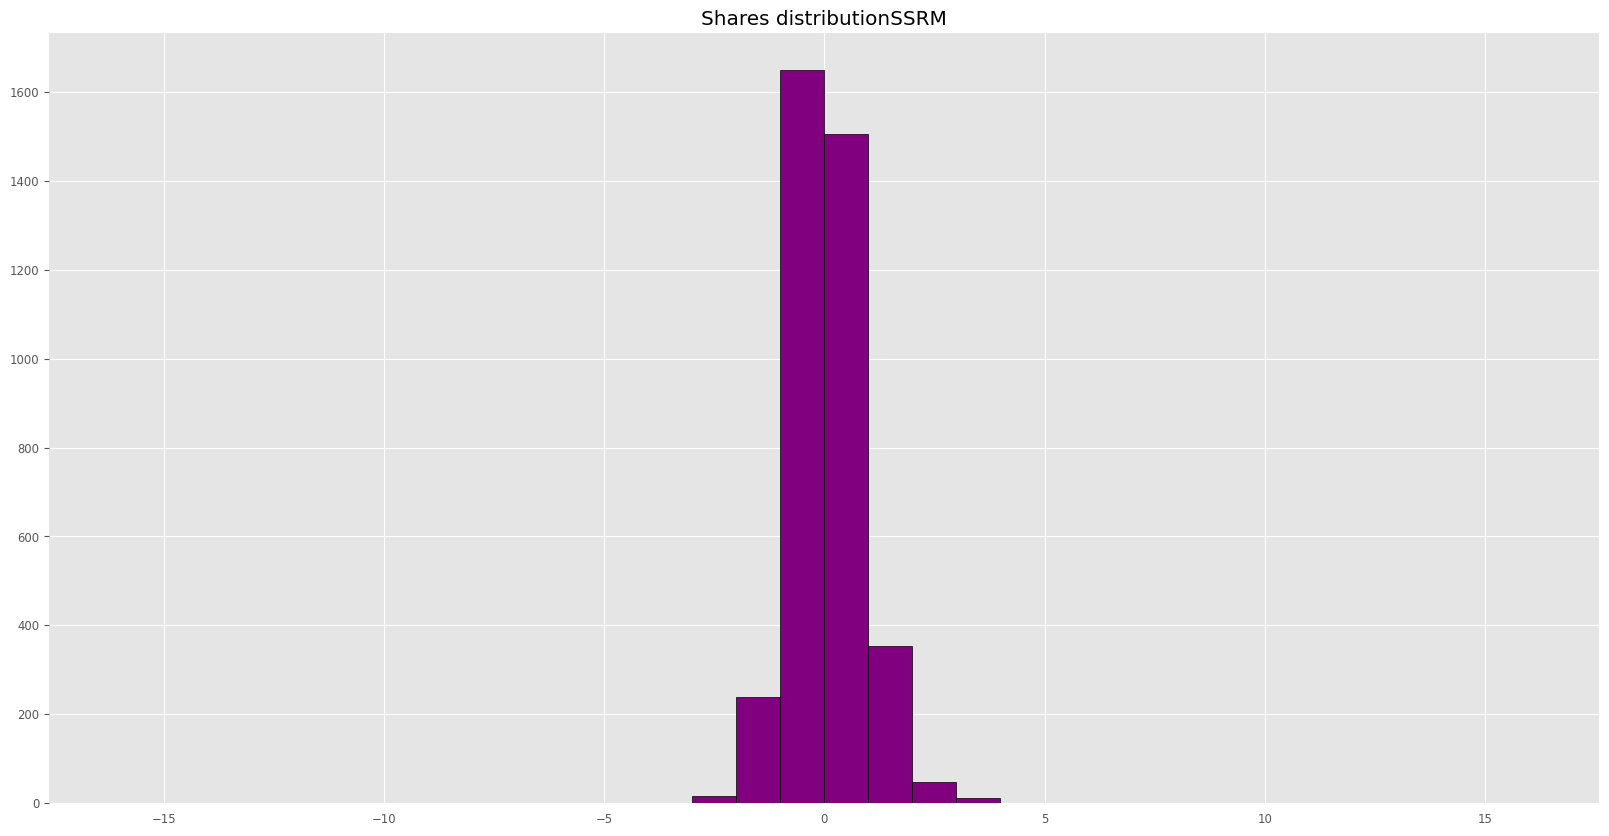

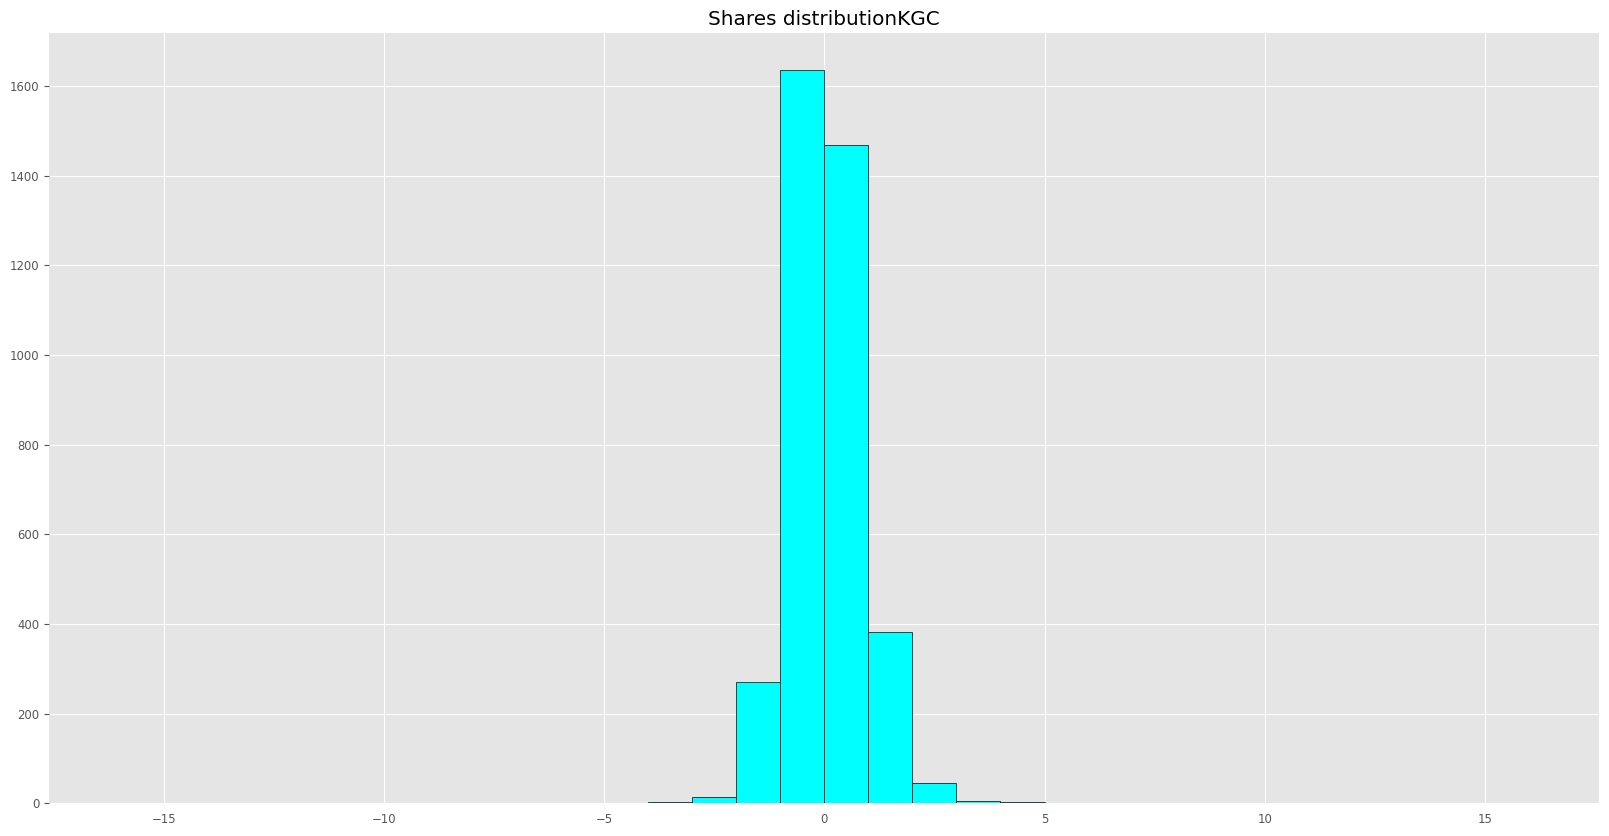

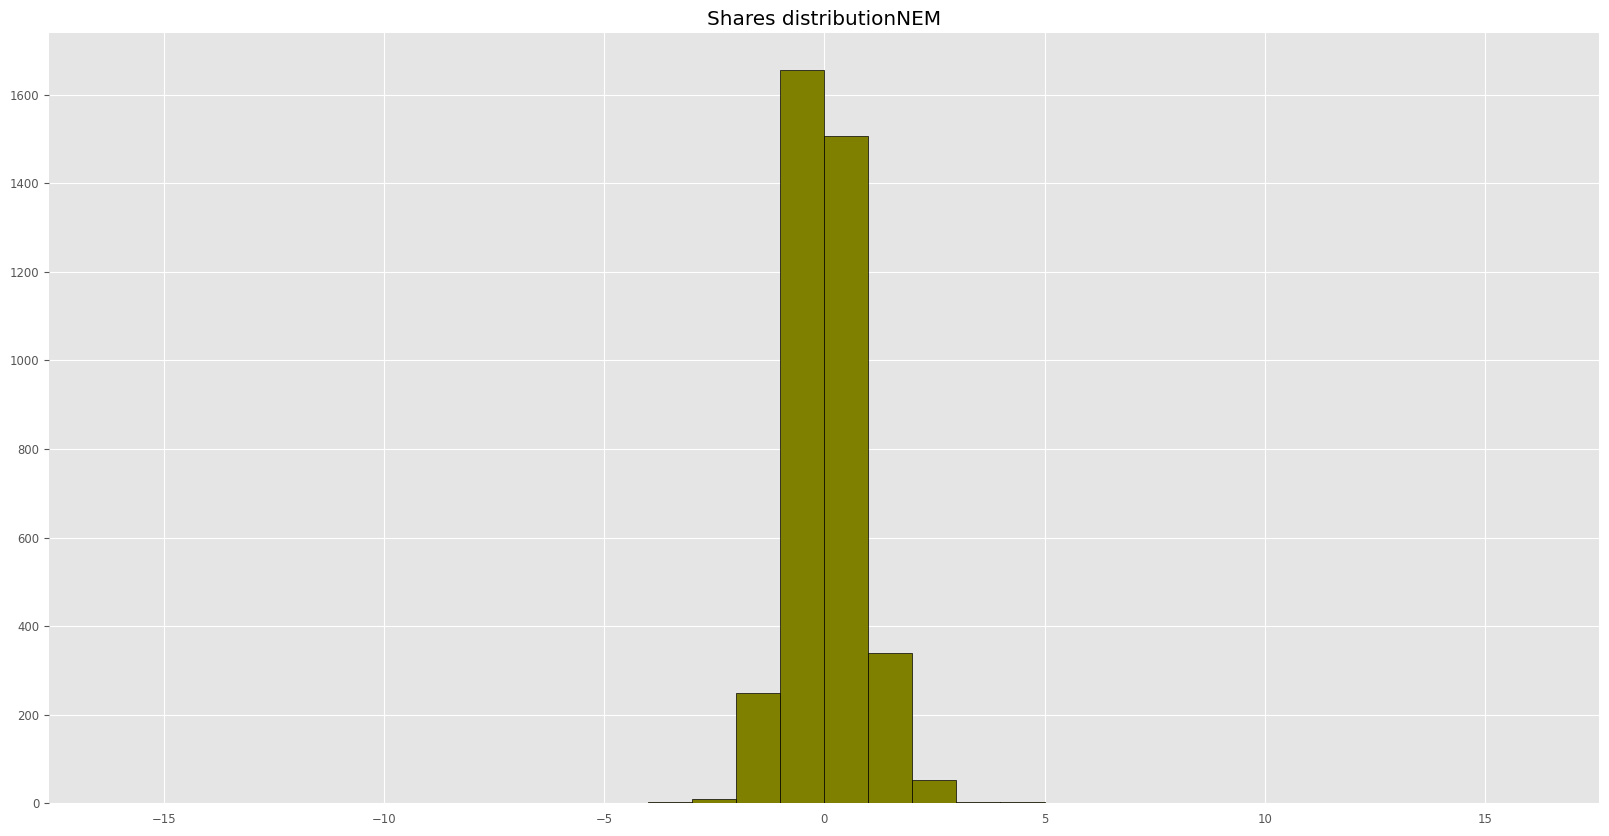

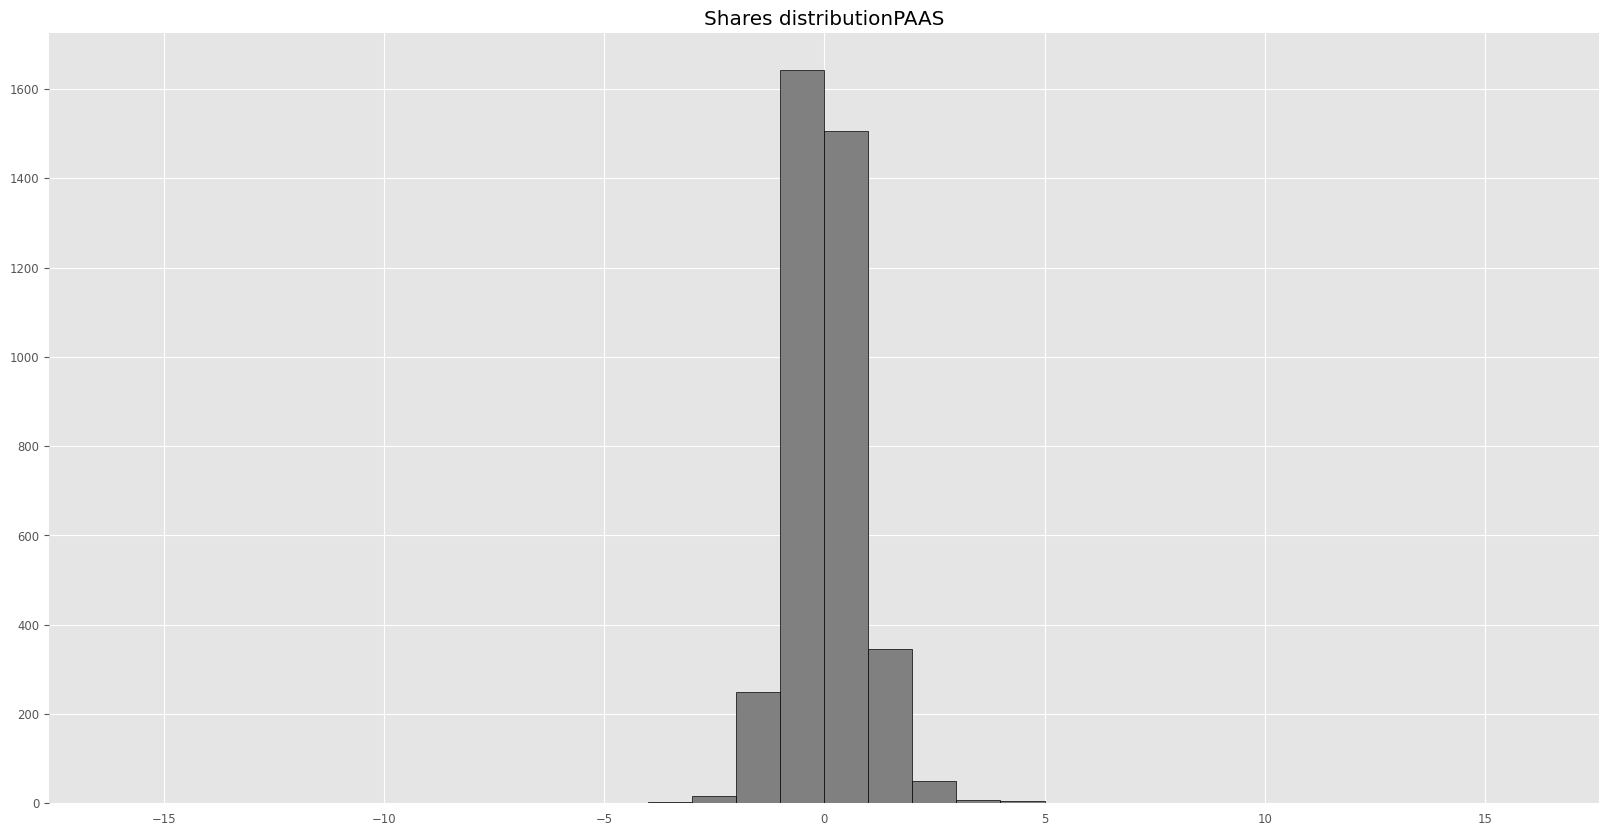

KeyError: "not all values found in index 'component'"

In [14]:
for idx, ticker in enumerate(ds.original.used_tickers):
    ds.covariates.series[idx][CONST.FEATURES.SHARES].plot(label=ticker)
plt.title("normalized shares")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    plt.hist( ds.covariates.series[idx][CONST.FEATURES.SHARES].values(), bins= [x  for x in range(-16,17)], color=COLORS[idx], edgecolor='black')
    plt.title("Shares distribution" + ticker)
    plt.show()

ds.covariates.series[0][CONST.FEATURES.GOLD_PRICE].plot(label="gold")
plt.title("normalized gold price")
plt.show()

ValueError: too many values to unpack (expected 1)

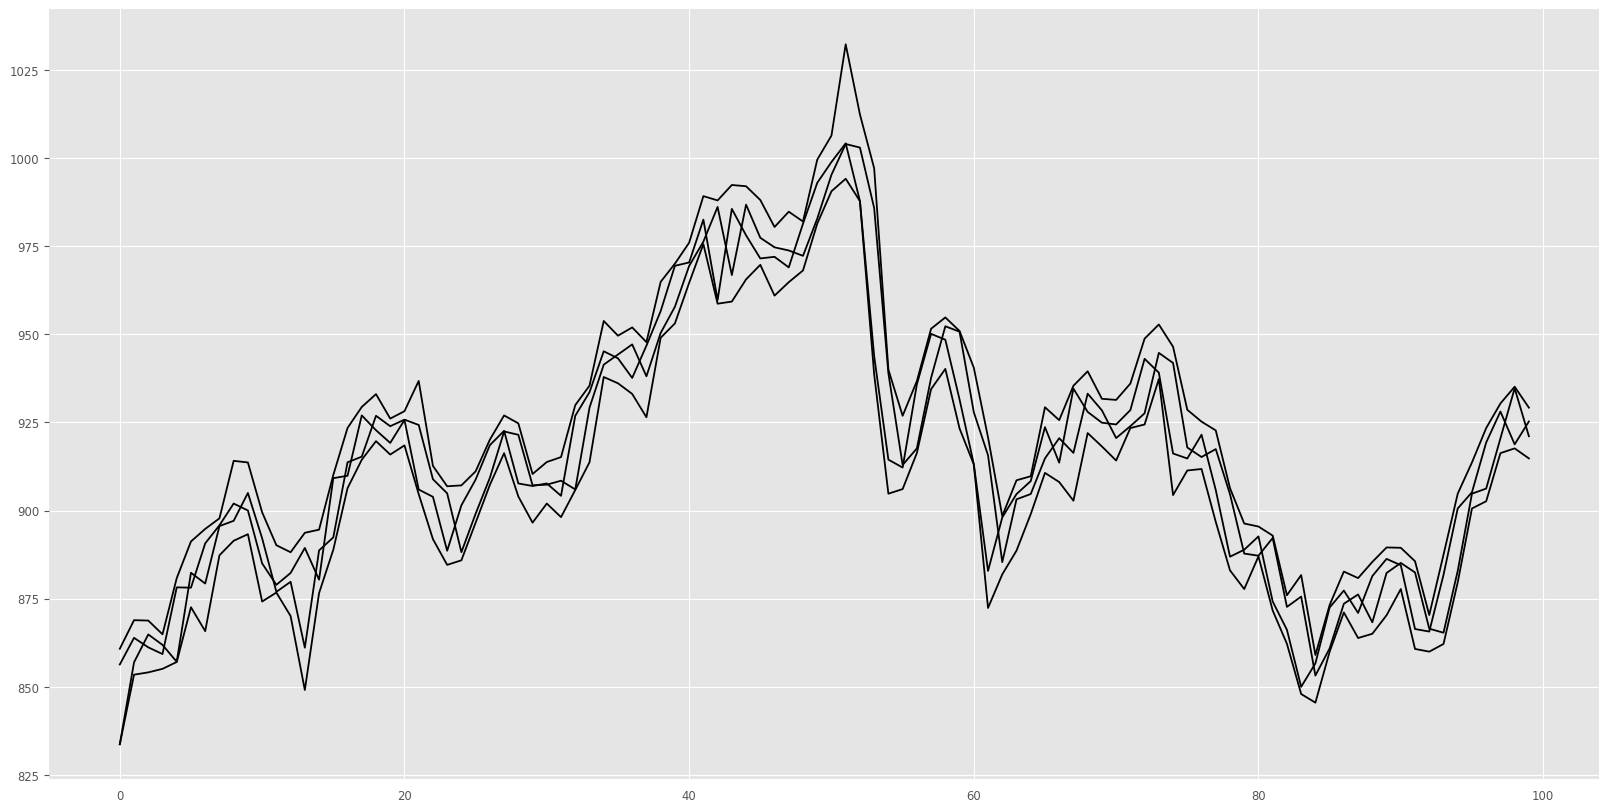

In [16]:
from smoothing import smooth

series = gold_ts[0:100]
plt.plot(range(0,100), series.values(), label=f"original", color="black")
for i in range (1,10):
    alpha = i / 10
    smoothed = smooth(series, alpha)
    plt.plot(range(0,100), smoothed.values(), label=f"aplha = {alpha}")


plt.legend(loc="upper right")
plt.title("smoothing")
plt.show()

In [17]:
my_dict = dict(zip(CONST.TICKERS,[x.pd_series() for x in ds.transformed.train]))
df = pd.DataFrame(my_dict)
df.describe()

,AEM,GFI,HMY,SSRM,KGC,NEM,PAAS
count,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000,3059.000000
mean,0.016253,0.004062,-0.006282,-0.001538,-0.020688,0.014098,0.007687
std,1.736273,1.914847,2.154578,2.168897,1.935455,1.406493,1.810522
min,-14.439297,-12.434443,-10.086860,-11.412718,-10.528349,-8.007085,-11.284549
25%,-0.833150,-1.009242,-1.234778,-1.143296,-1.044399,-0.735250,-0.957309
50%,0.025288,-0.039312,-0.120319,0.017857,-0.070911,-0.003894,0.007298
75%,0.870669,0.954641,1.137995,1.099187,0.959621,0.732019,0.973491
max,11.182439,15.250242,16.706152,14.411875,11.758322,12.371439,12.497889


c:\repos\nasdaq_forecasting\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


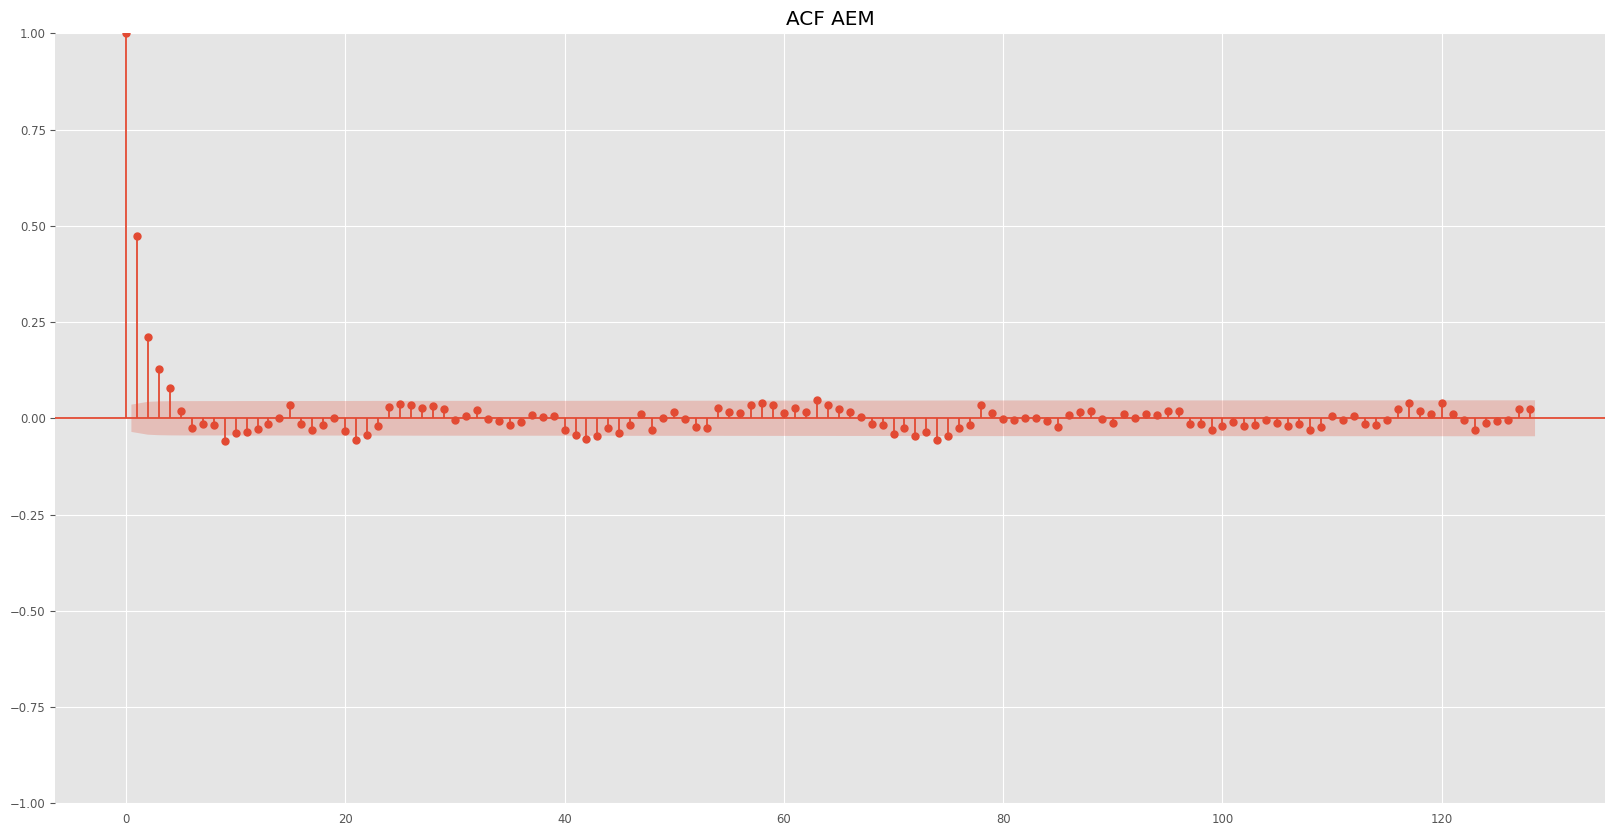

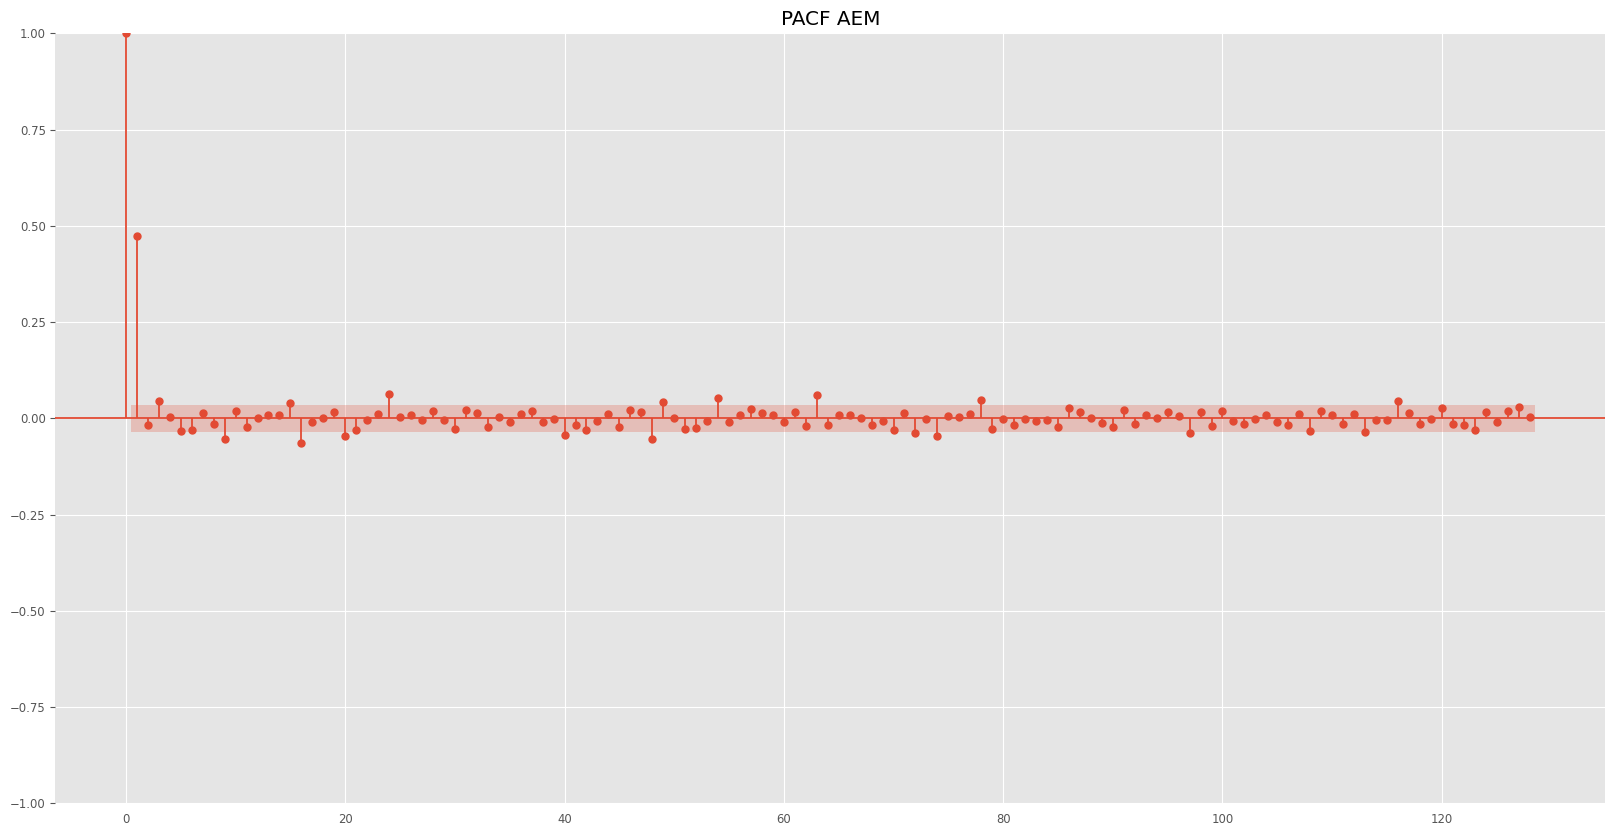

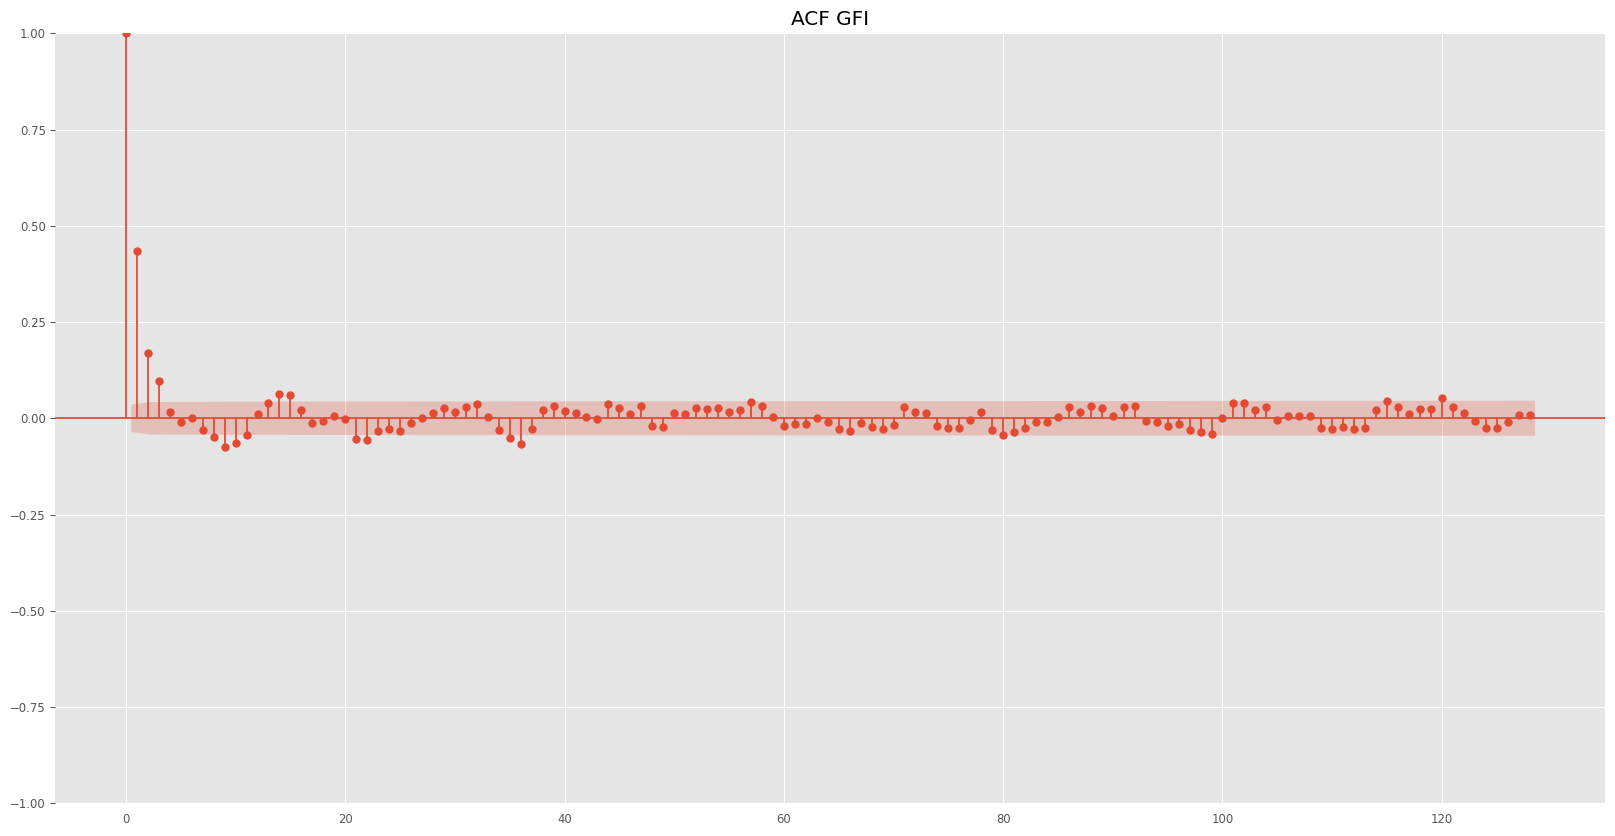

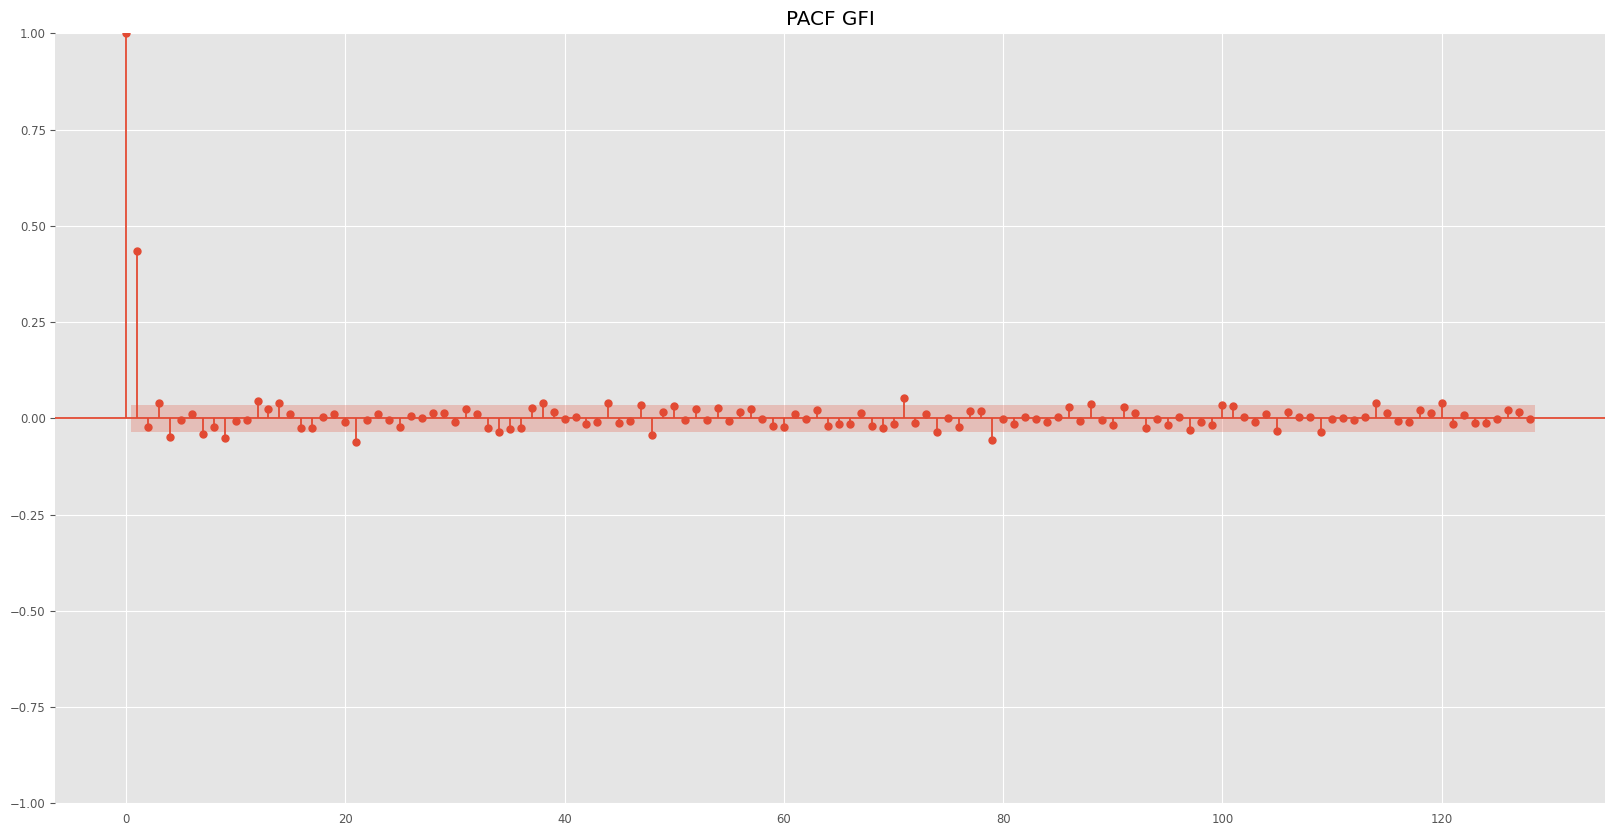

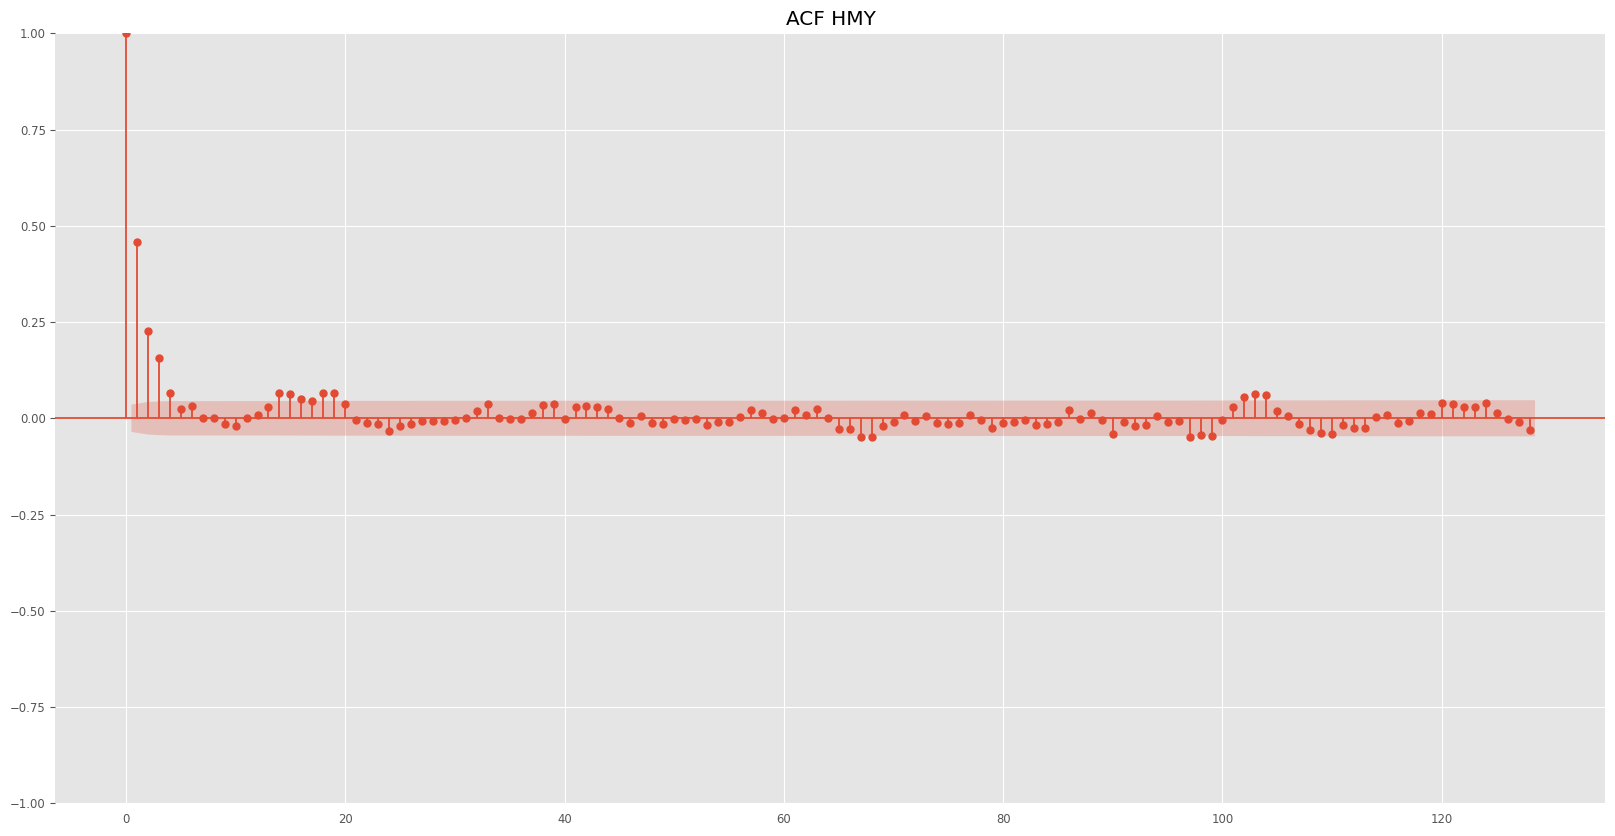

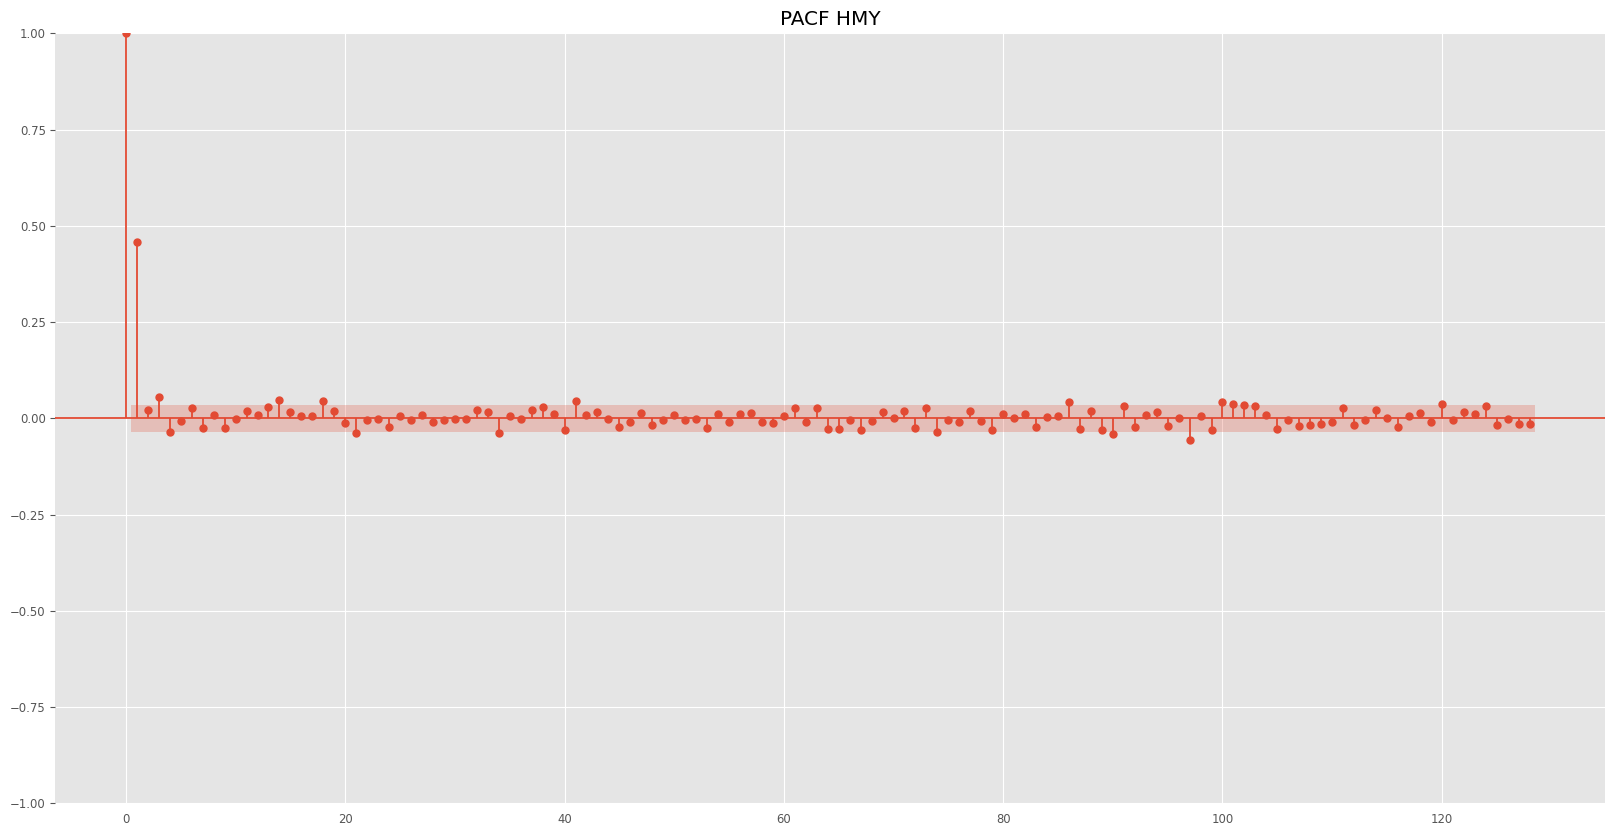

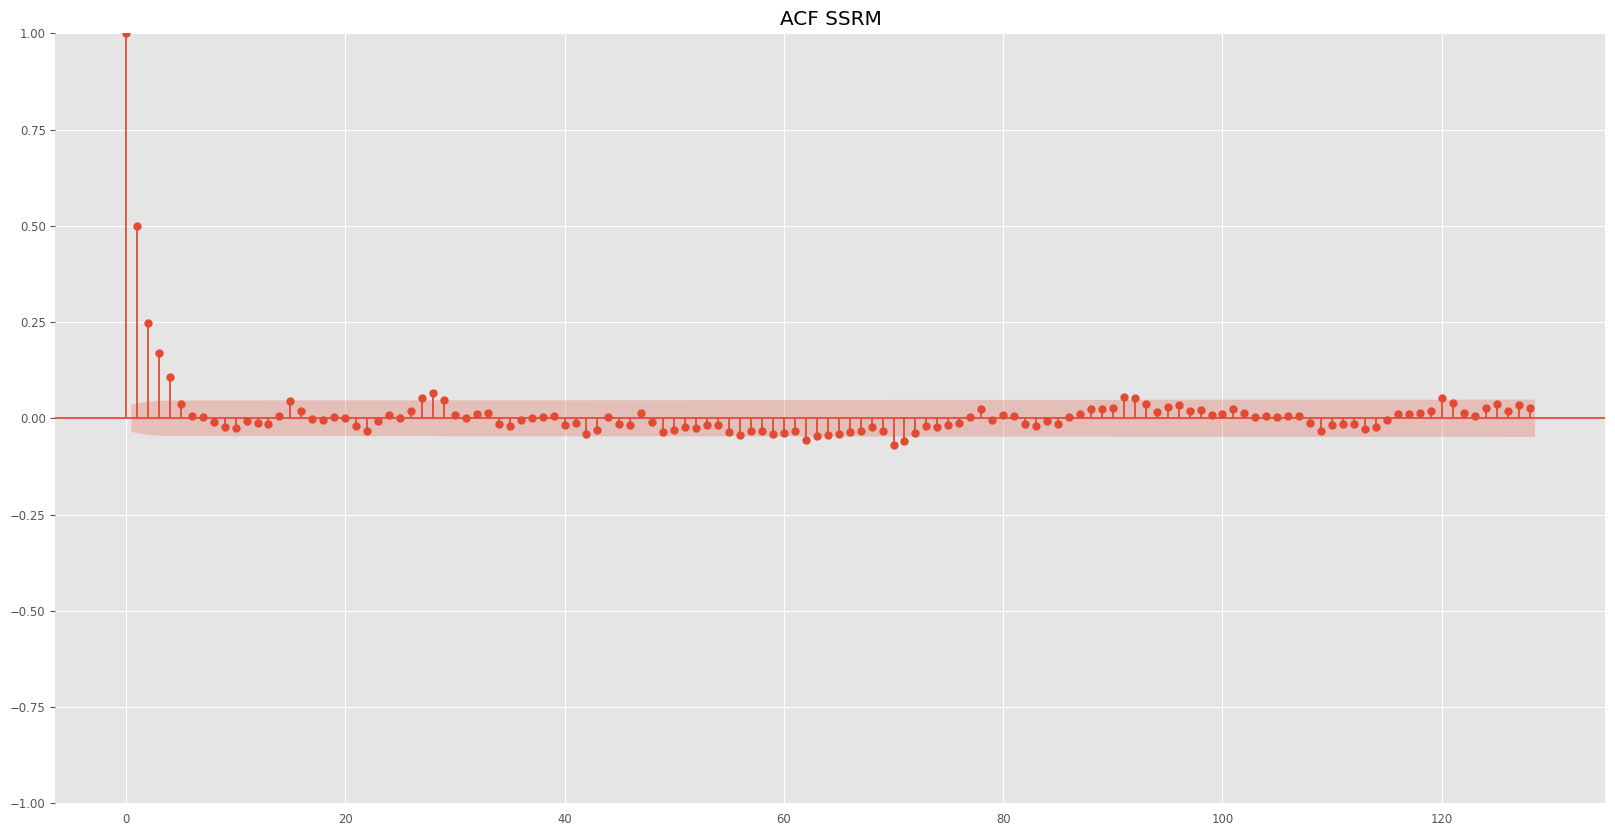

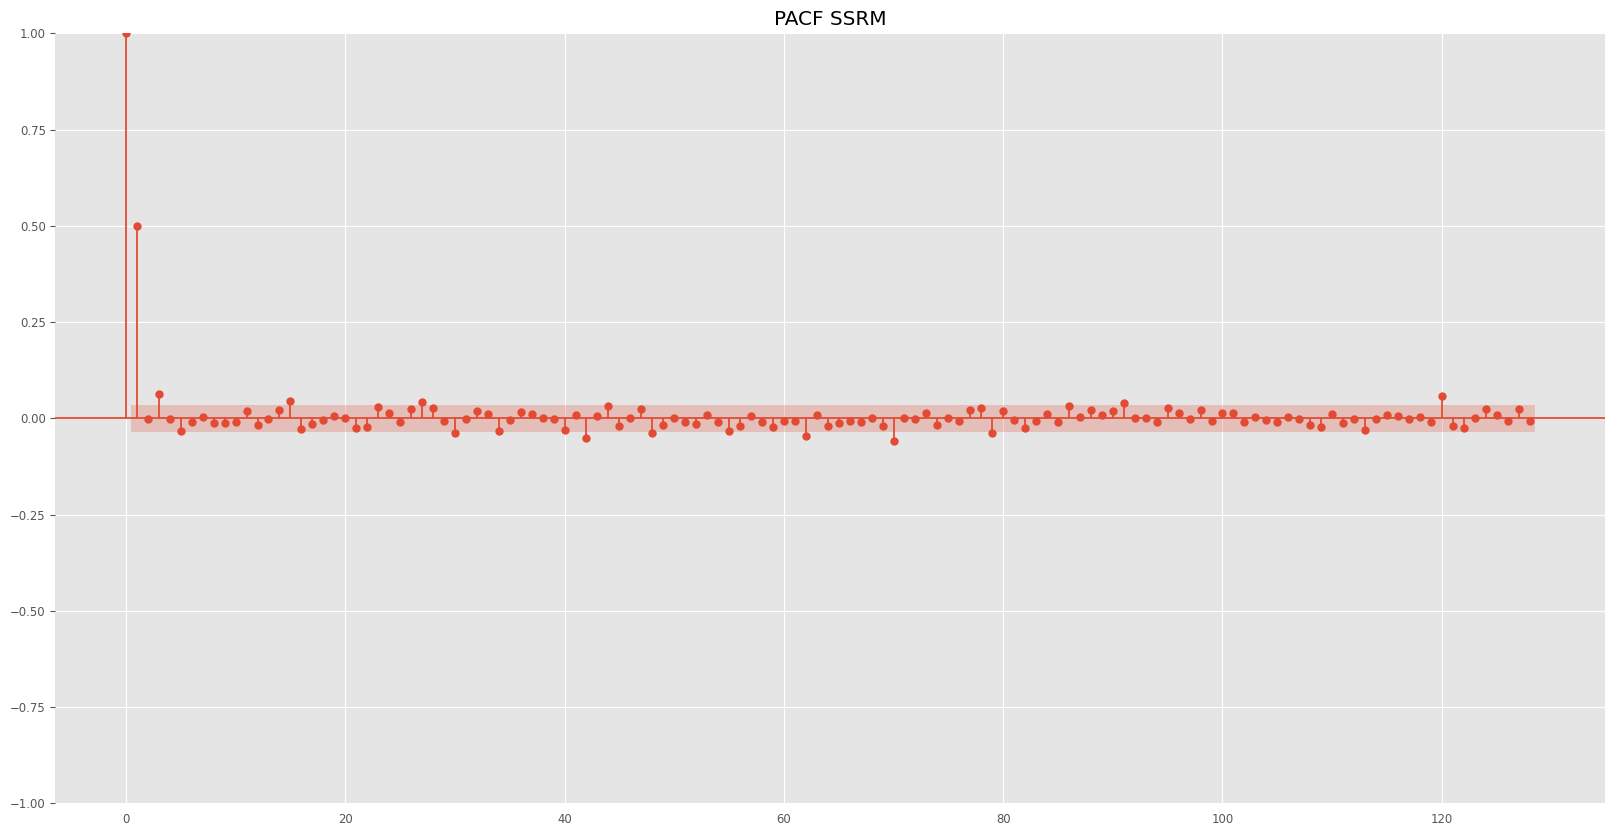

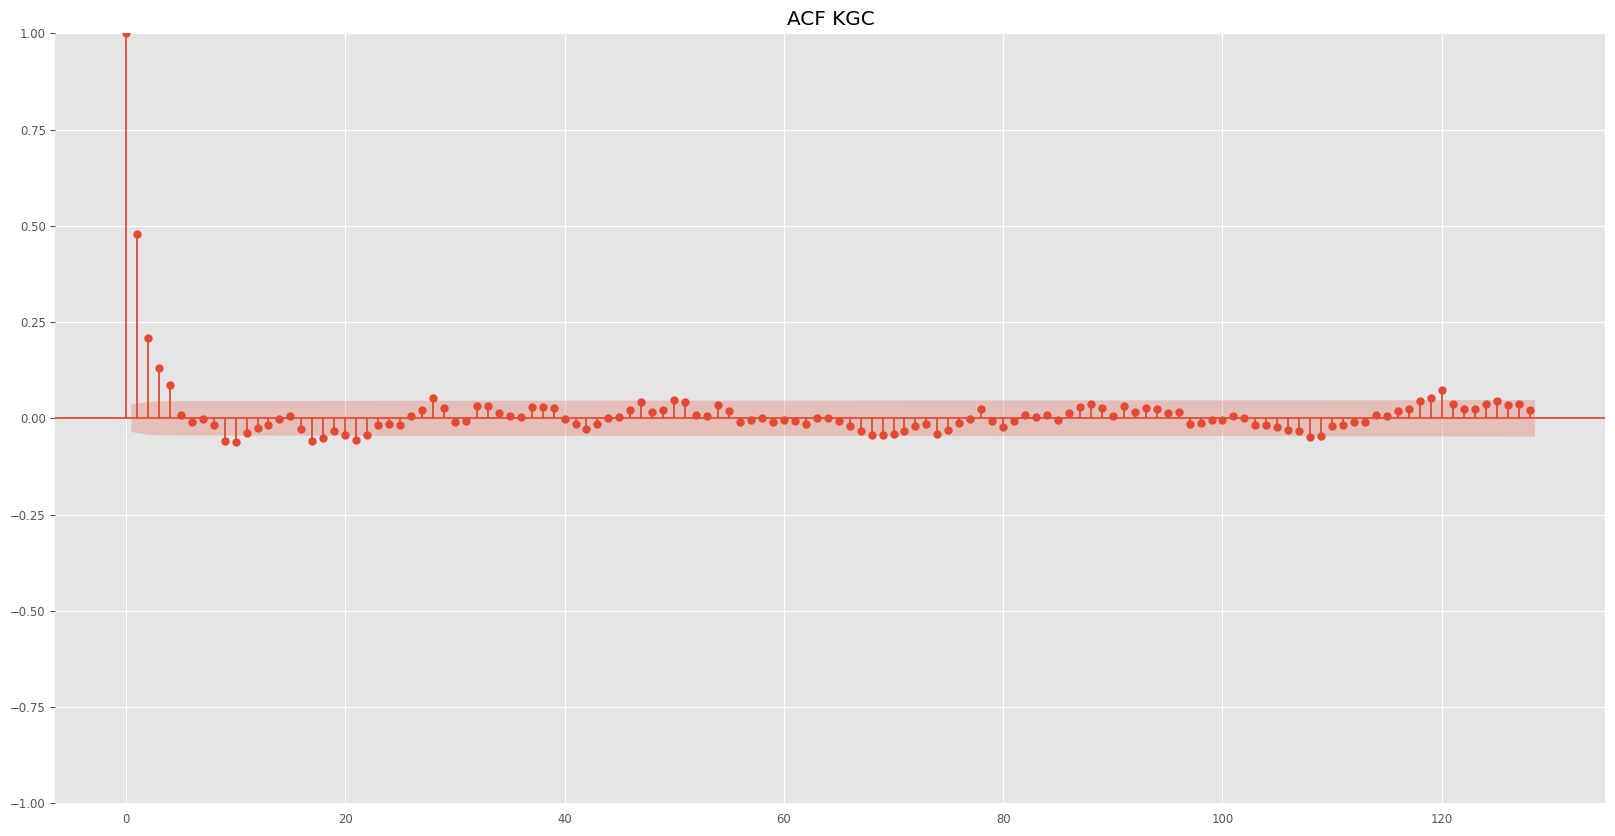

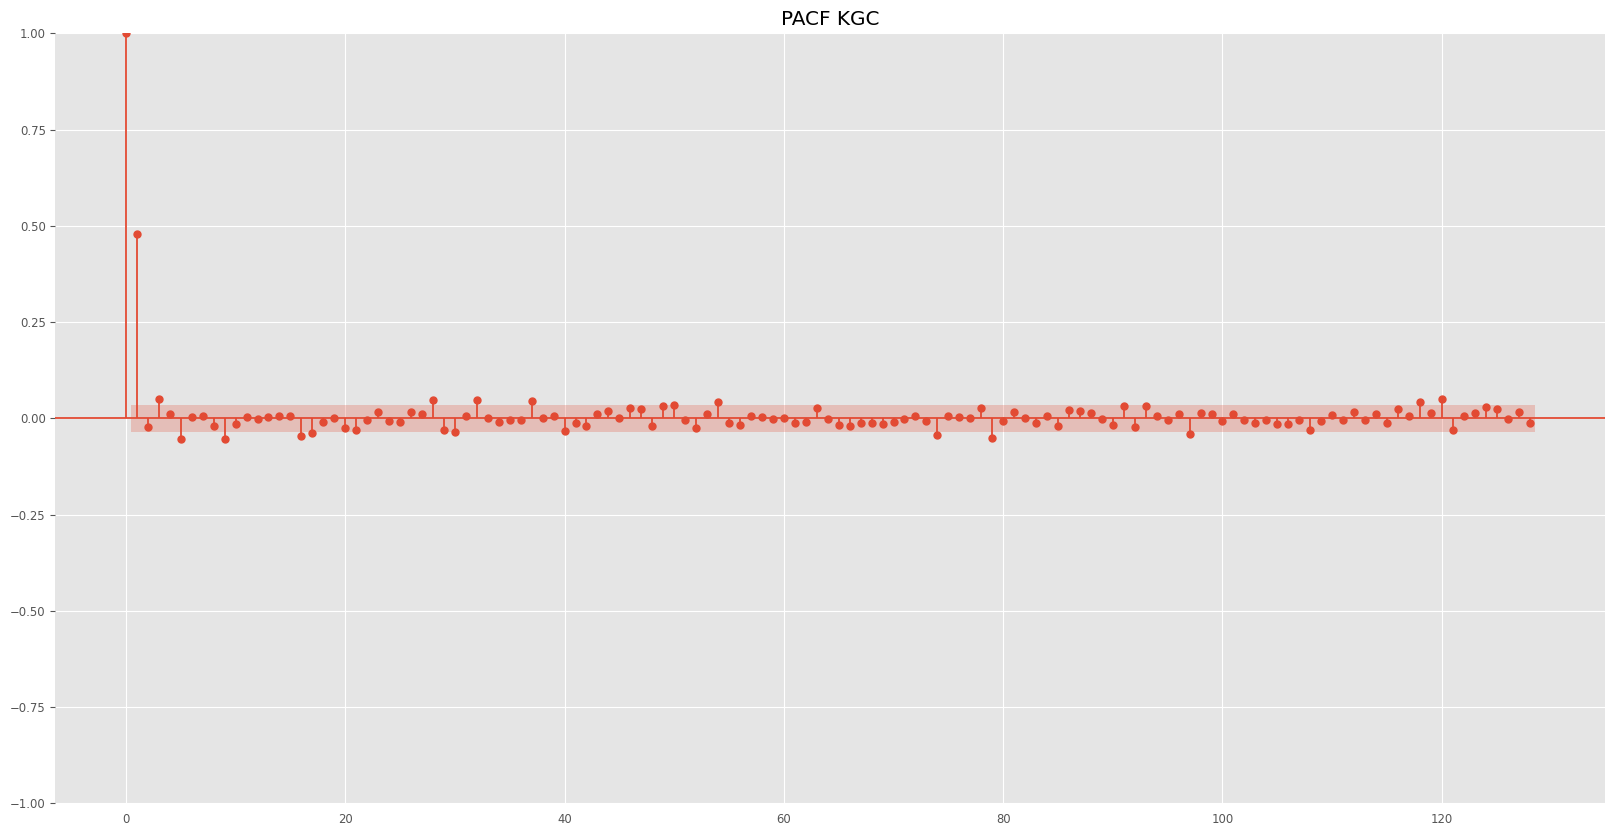

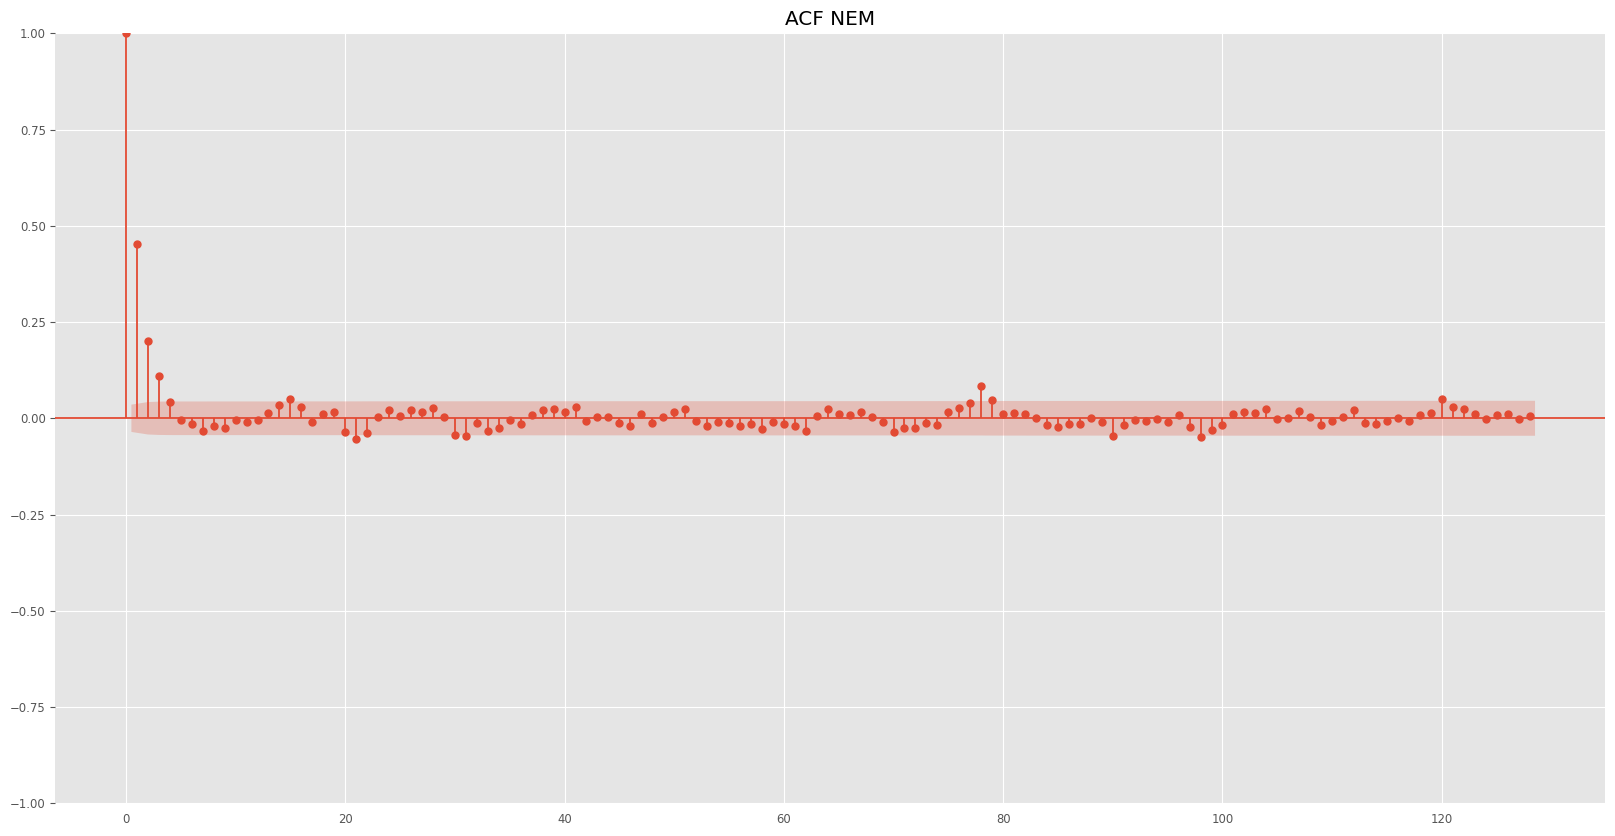

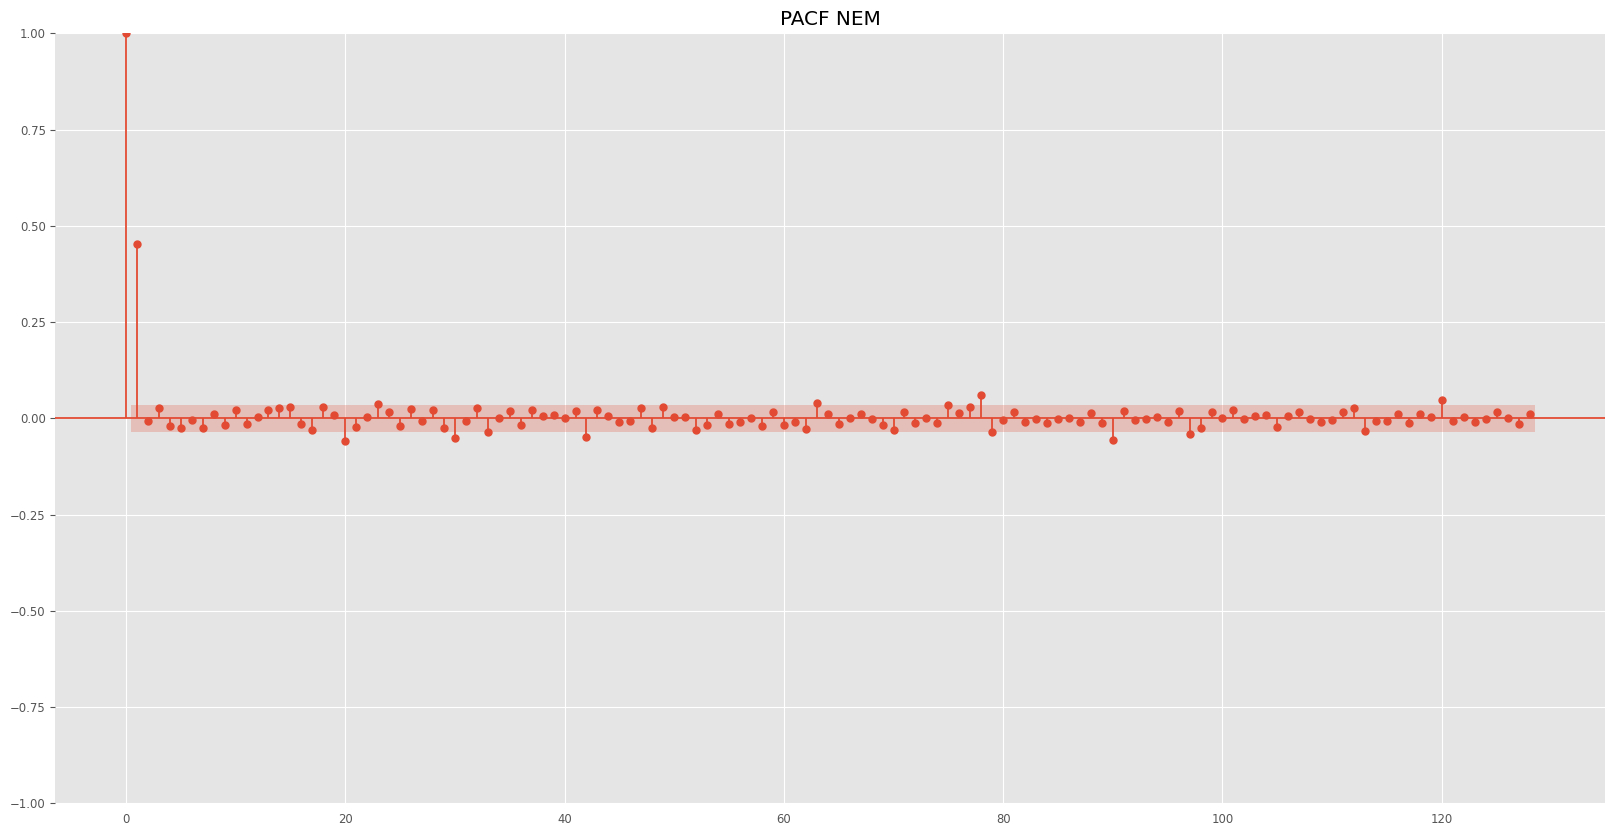

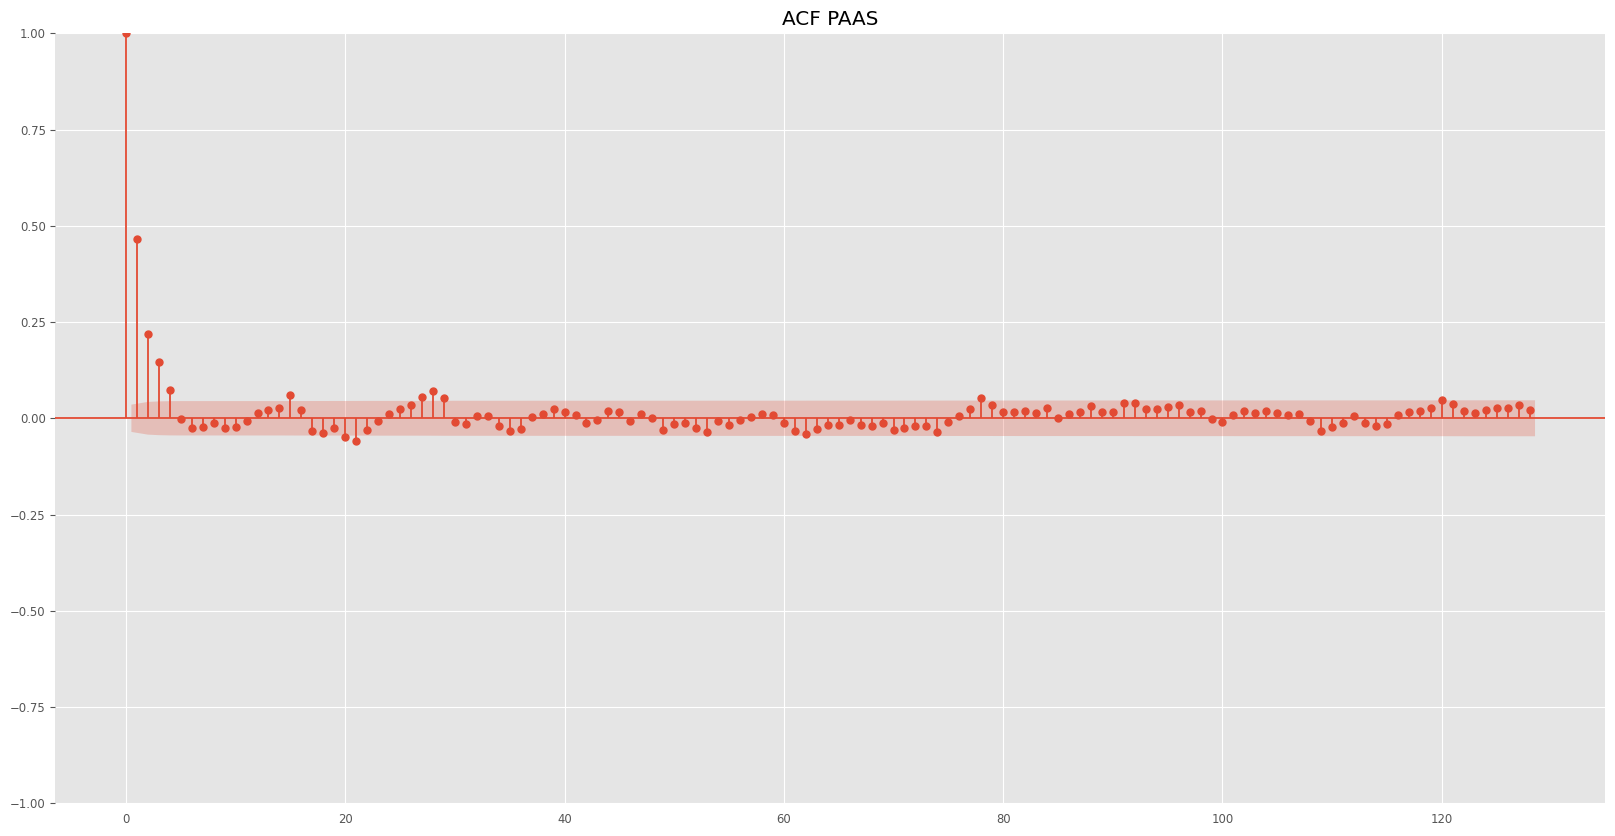

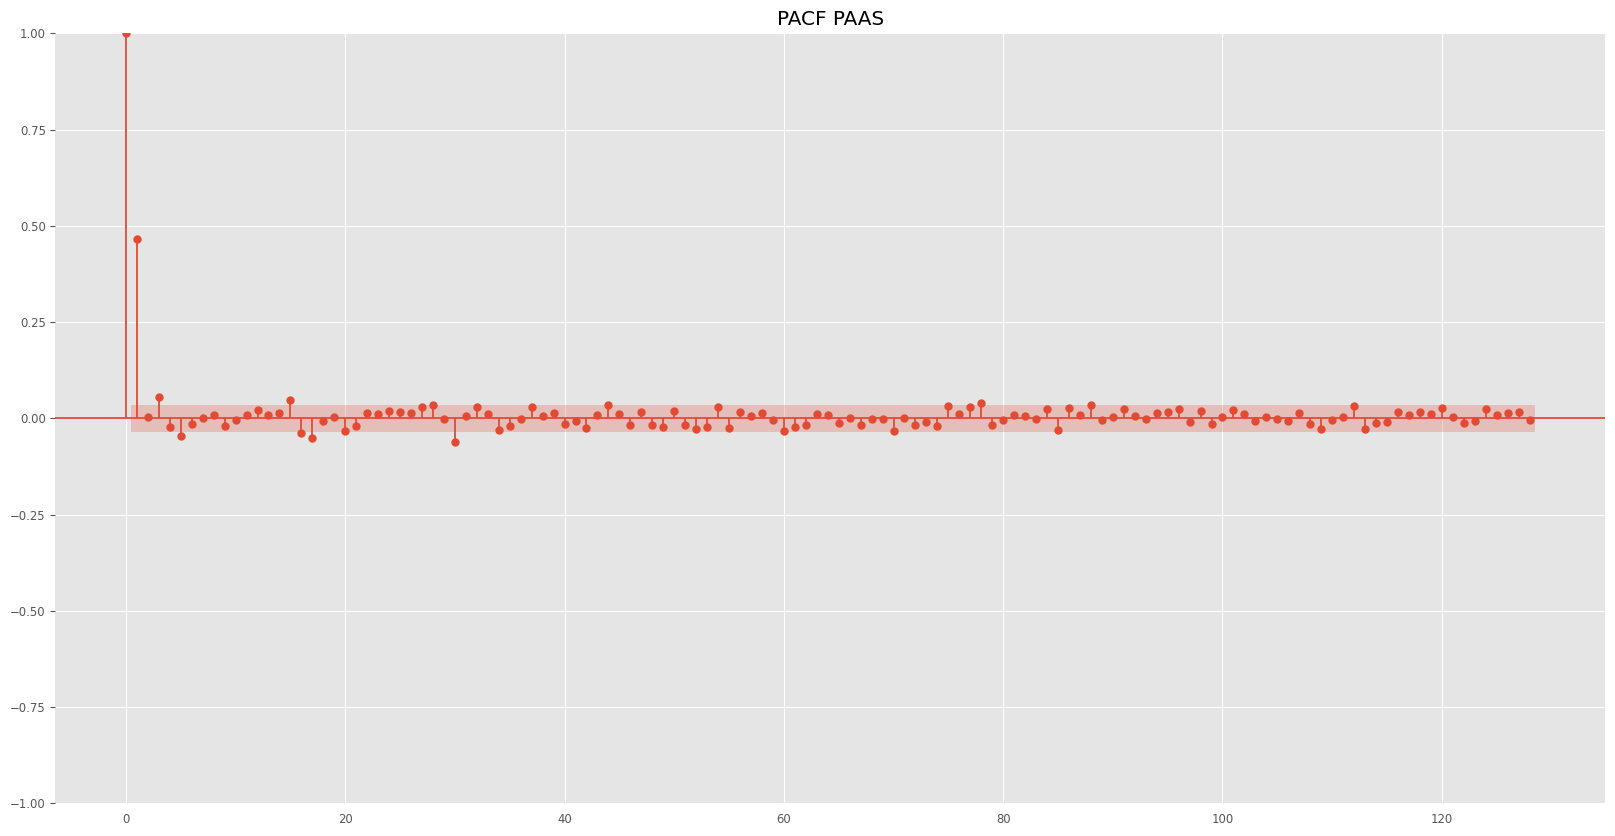

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for ticker in CONST.TICKERS:
    plot_acf(df[ticker], lags=128, title="ACF " + ticker)
    plot_pacf(df[ticker],lags=128, title="PACF " + ticker)

In [19]:
import darts.utils.statistics as statistics
# Stationary 
stats_df = pd.DataFrame({ CONST.FEATURES.PRICE: [], f"normalized {CONST.FEATURES.PRICE}": [], f" normalized {CONST.FEATURES.SHARES}": []})
p_threshold = 0.05
def test_stationarity(timeseries: TimeSeries):
    return statistics.stationarity_test_adf(timeseries)[1]

for idx,ticker in enumerate(ds.original.used_tickers):
    price_stationarity = test_stationarity(ds.original.train[idx])
    normalized_price_stationarity = test_stationarity(ds.transformed.train[idx])
    shares_stationarity = test_stationarity(ds.covariates.train[idx][CONST.FEATURES.SHARES])
    stats_df.loc[ticker] = [price_stationarity,normalized_price_stationarity,shares_stationarity]

print(stats_df)
print(stats_df < p_threshold)

      adjclose  normalized adjclose   normalized volume
AEM   0.076516         3.414957e-20        5.390713e-29
GFI   0.553885         4.085030e-23        7.509338e-28
HMY   0.592112         0.000000e+00        0.000000e+00
SSRM  0.008288         0.000000e+00        2.496995e-30
KGC   0.283046         2.515382e-30        6.678945e-29
NEM   0.307314         0.000000e+00        1.528975e-29
PAAS  0.102499         0.000000e+00        0.000000e+00
      adjclose  normalized adjclose   normalized volume
AEM      False                 True                True
GFI      False                 True                True
HMY      False                 True                True
SSRM      True                 True                True
KGC      False                 True                True
NEM      False                 True                True
PAAS     False                 True                True


In [20]:
correlations = df.corrwith(ds.covariates.train[0][CONST.FEATURES.GOLD_PRICE].pd_series())
print("Gold spot price correlation")
print(correlations)

KeyError: "not all values found in index 'component'"

In [21]:
price_shares_corr = []
for column in df.columns:
    corr = df[column].corr(ds.covariates.train[idx][CONST.FEATURES.SHARES].pd_series())
    price_shares_corr.append(corr)

In [22]:
print(price_shares_corr)

[0.026088236727275973, 0.047035461246813265, 0.04510058919056765, 0.028604006670832054, 0.04163953199387577, 0.03549650801593979, 0.028326937383948446]


In [23]:
cov_df = ds.covariates.train[0].pd_dataframe()
cov_df.drop(columns=["volume"],inplace=True)
print(df.head())
print(cov_df.head())

                 AEM       GFI       HMY      SSRM       KGC       NEM   
date                                                                     
2008-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
2008-01-03  1.751595  2.694792  3.860461  0.898726  1.637720  1.355220   
2008-01-04  0.365148  1.248793  2.082400 -2.728641  0.048828 -0.640316   
2008-01-07  0.701646 -0.882116  1.019960 -4.523763 -0.268424 -1.175152   
2008-01-08  2.051615  2.642372  1.937901  0.319136  2.165406  0.613737   

                PAAS  
date                  
2008-01-02  0.000000  
2008-01-03 -0.107508  
2008-01-04 -1.789566  
2008-01-07 -2.007121  
2008-01-08  1.436562  
component   month_sin  month_cos  weekday_sin  weekday_cos  INFLATION   
date                                                                    
2008-01-02        0.5   0.866025     0.974928    -0.222521        0.0  \
2008-01-03        0.5   0.866025     0.433884    -0.900969        0.0   
2008-01-04        0.5   0.86

In [24]:
cov_corr = {}
for column in cov_df.columns:
    corr = df.corrwith(cov_df[column])
    cov_corr[column] = corr

pd.DataFrame(cov_corr)

,month_sin,month_cos,weekday_sin,weekday_cos,INFLATION,^GSPC,ES=F,GC=F,GOLD,SI=F,SILVER,XLF
AEM,0.029328,-0.011163,-0.015214,-0.025811,-0.026536,0.188257,0.212359,0.603704,0.680648,0.534542,0.600142,0.068775
GFI,0.015304,0.022991,0.014600,-0.017532,-0.032507,0.182727,0.214102,0.516805,0.617221,0.464183,0.543836,0.104832
HMY,0.037362,0.064078,0.024190,-0.006186,-0.028642,0.128880,0.166562,0.505320,0.604339,0.436958,0.517583,0.058871
SSRM,0.038849,-0.001432,0.004235,-0.019557,-0.028631,0.290271,0.321452,0.559892,0.622919,0.591974,0.655493,0.179504
KGC,0.025256,0.006957,-0.002466,-0.029983,-0.028173,0.192399,0.224117,0.566204,0.655357,0.523914,0.596173,0.079788
NEM,0.035938,0.009413,-0.007401,-0.026385,-0.034109,0.261611,0.277125,0.581151,0.660820,0.525556,0.596350,0.128944
PAAS,0.026254,0.019330,0.000401,-0.026539,-0.013386,0.297411,0.319694,0.567532,0.648034,0.584807,0.666442,0.172682
